In [1]:
import os
import time
import math
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import warnings
import torch
import torch.optim as optim
import scipy.stats

from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, get_torch_criterion
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting Visitor Arrivals
Full train on Covid period

## Baseline of simple SARIMA 

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
# aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.09022556390977443

In [7]:
test_y

Date
2022-02-01     233.0
2022-03-01     294.0
2022-04-01     380.0
2022-05-01     404.0
2022-06-01     430.0
2022-07-01     537.0
2022-08-01     648.0
2022-09-01     579.0
2022-10-01     822.0
2022-11-01    1023.0
2022-12-01    1372.0
2023-01-01     872.0
Name: VisitorArrivals, dtype: float64

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


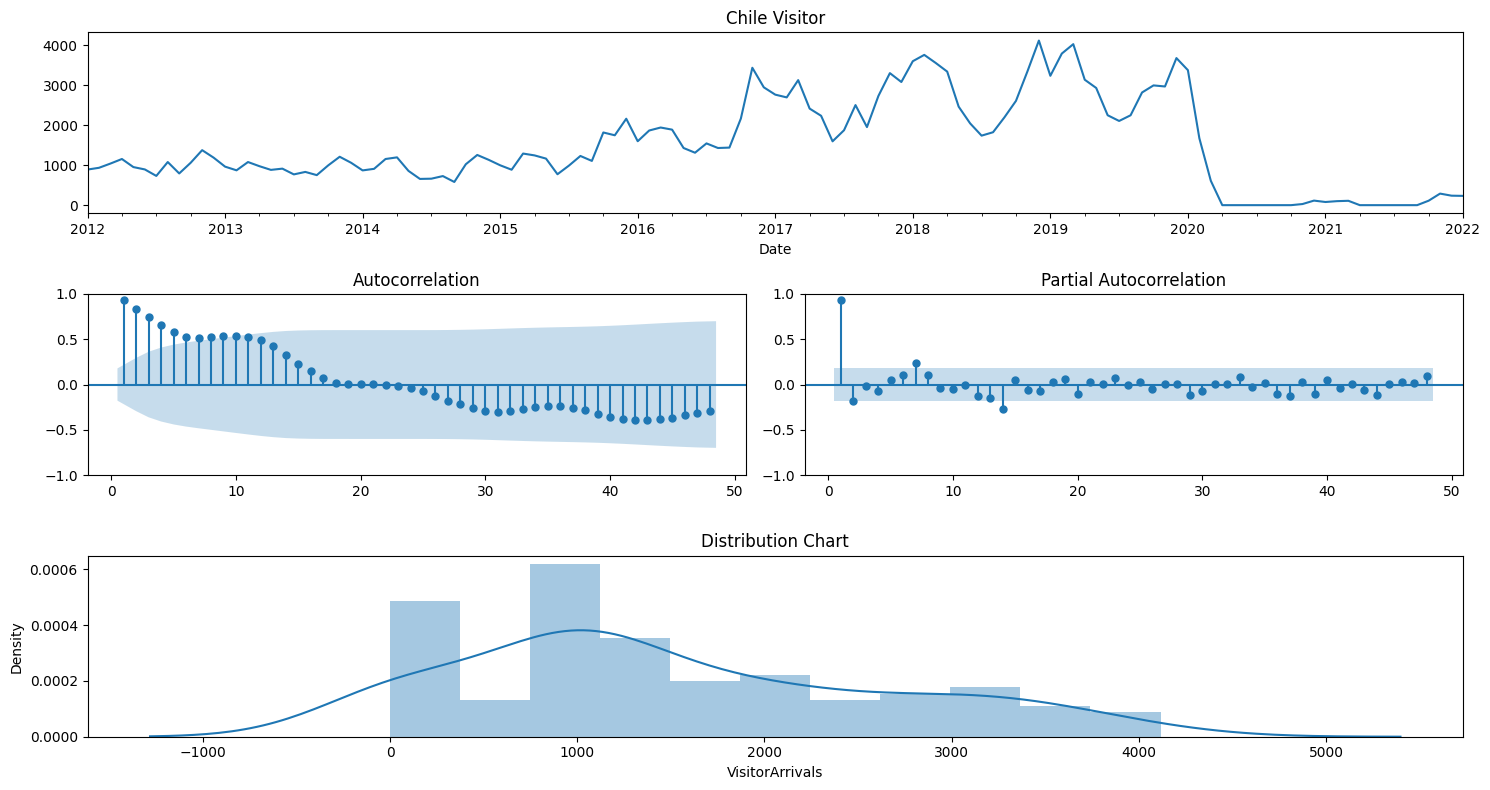

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 0), (1, 0, 1, 12), 'c'] 246.85707446376617


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 430.64541656542326
R2 -0.8005390759590416


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

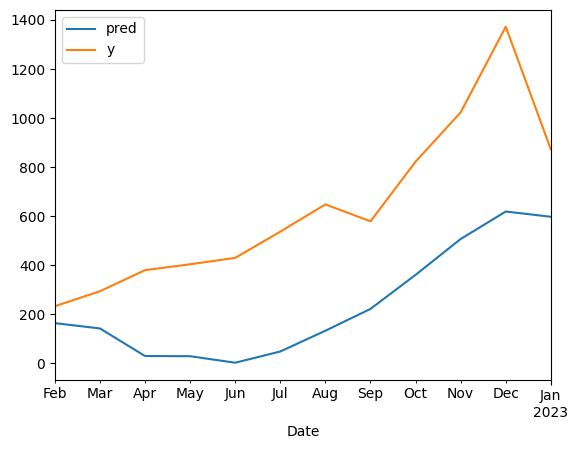

In [9]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [10]:
# repeat for chile and maldives
sarima_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        train_y = df[target]
        train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
        train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True, init_repeat=False)
        print(best_param, best_rmse, best_r2)
        sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarima_model.fit(disp=False)
        pred = result.forecast(len(test_y))
        sarima_pred.append(pred)
        all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values

processing Japan.csv
[(2, 0, 1), (0, 0, 0, 12), 'n'] 100876.5180375239 None
processing Korea (ROK).csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[(1, 1, 0), (0, 0, 0, 12), 'n'] 151705.66074286433 None
processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/

[(1, 0, 0), (1, 0, 1, 12), 'c'] 246.85707446376617 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (0, 0, 1, 12), 'n'] 1917.0737784120668 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

processing Cambodia.csv
[(1, 0, 1), (1, 0, 1, 12), 'c'] 14820.213999536156 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Singapore.csv
[(2, 0, 1), (0, 0, 0, 12), 'n'] 45775.13770294937 None
processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[(2, 0, 0), (1, 0, 1, 12), 'n'] 32137.822382147355 None
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 0, 1), (1, 0, 1, 12), 'n'] 20546.371323931624 None
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[(1, 0, 1), (0, 0, 0, 12), 'n'] 138263.9564738949 None
processing Indonesia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 0, 1), (0, 0, 0, 12), 'n'] 26735.276650902386 None
processing Turkey.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

[(1, 1, 1), (1, 0, 1, 12), 'c'] 1887.2926632321655 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Macao, China.csv
[(1, 0, 0), (0, 0, 0, 12), 'c'] 526214.2798990703 None
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(2, 0, 0), (0, 0, 0, 12), 'n'] 17043.271011756762 None
processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(2, 1, 1), (1, 0, 0, 12), 'c'] 2144.592839186564 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

processing Czech.csv
[(2, 0, 1), (1, 0, 0, 12), 'n'] 3816.914574431871 None
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

[(2, 0, 1), (1, 0, 0, 12), 'c'] 419.9971604375902 None
processing Mexico.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (0, 0, 0, 12), 'c'] 1192.34611341122 None
processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[(1, 0, 0), (0, 0, 0, 12), 'n'] 790052.2012356383 None
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/

[(3, 0, 0), (1, 0, 0, 12), 'n'] 3021.3881003965794 None
processing Austria.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(3, 1, 1), (1, 0, 0, 12), 'n'] 1824.7190402019367 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


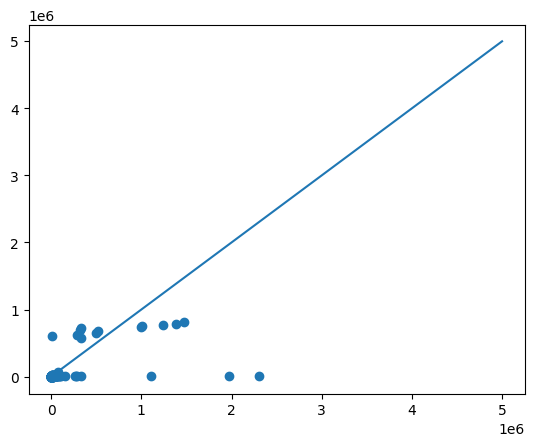

In [15]:
plt.scatter(all_y, sarima_pred)
plt.plot((0, 5000000), (0, 5000000))

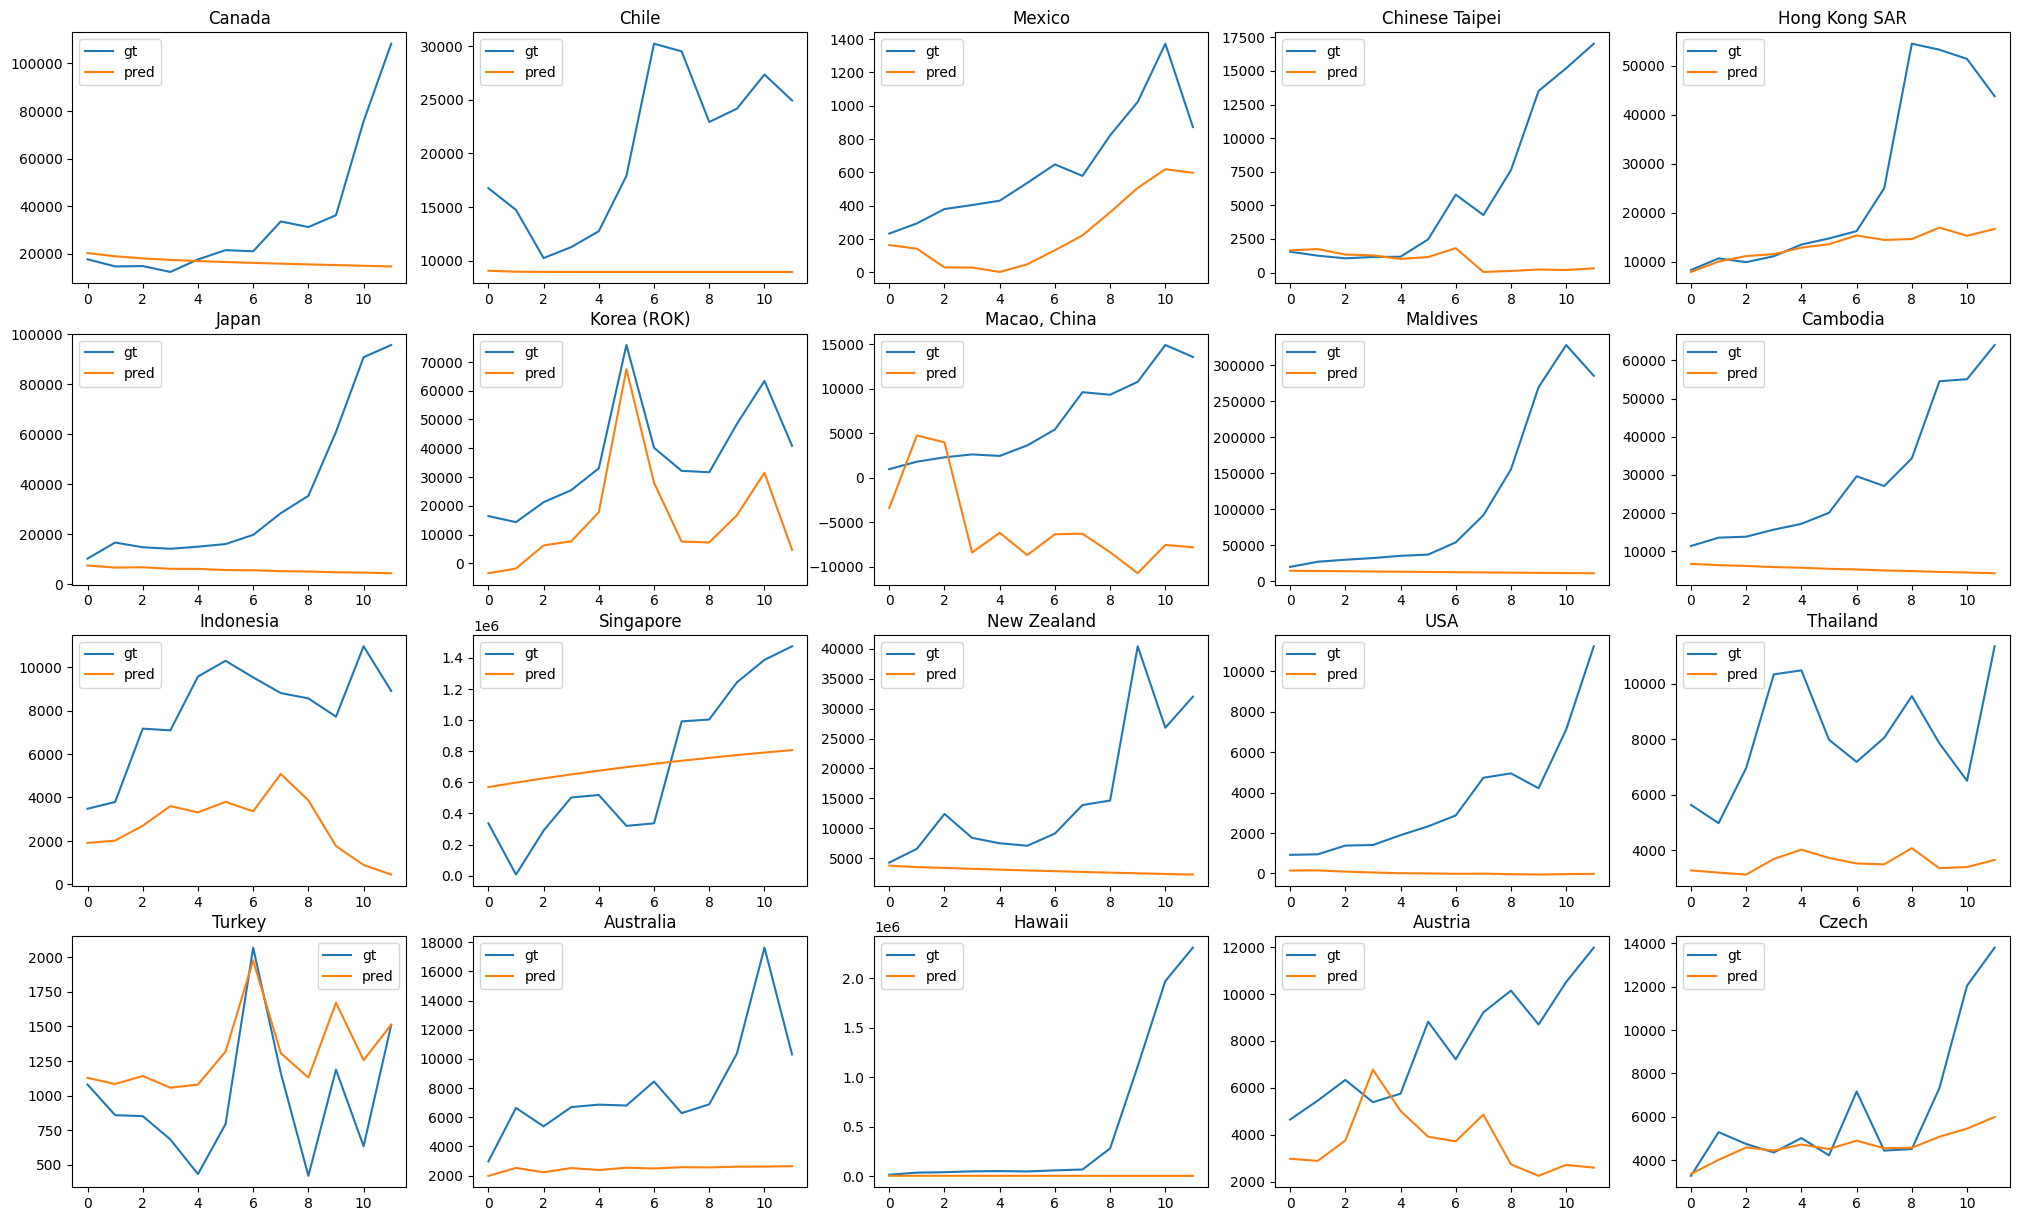

In [16]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(sarima_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [17]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
baseline_mae = mean_absolute_error(all_y, sarima_pred)
baseline_mape = mean_absolute_percentage_error(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}\nBaseline SARIMA MAE: {baseline_mae:.5f}\nBaseline SARIMA MAPE: {baseline_mape:.5f}')

Baseline SARIMA RMSE: 231295.49112
Baseline SARIMA R2: 0.28842
Baseline SARIMA MAE: 57298.95961
Baseline SARIMA MAPE: 1.03003


# Preprocessing Data

In [8]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove_covid=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove_covid:
        df = df[df['Date'] < ('2019-07-01' if country in ['Hong Kong SAR', 'Chinese Taipei'] else '2020-01-01')]
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [9]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1997-01-01 to 2024-07-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            331 non-null    float64
 1   CovidCases                319 non-null    float64
 2   CovidDeaths               319 non-null    float64
 3   FSI                       331 non-null    float64
 4   GDPPerCap                 331 non-null    float64
 5   GDP                       331 non-null    float64
 6   Population                331 non-null    float64
 7   TravelPolicy              331 non-null    float64
 8   Temperature               331 non-null    float64
 9   Precipitation             331 non-null    float64
 10  GlobalCovidTrend          331 non-null    float64
 11  DistFromChina             331 non-null    float64
 12  Country                   331 non-null    object 
 13  GDPRatioChina             331 non-nul

<Axes: >

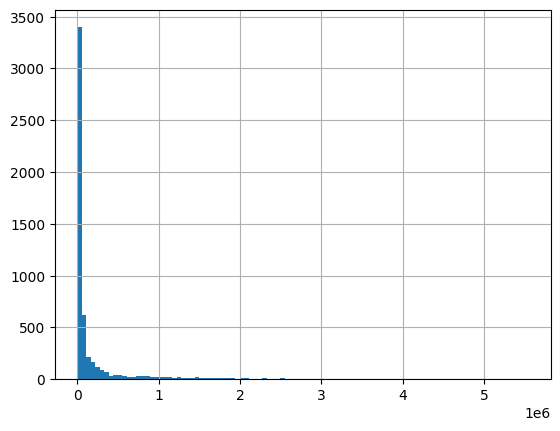

In [10]:
pd.concat([load_data(country, log_transform=False)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)

<Axes: >

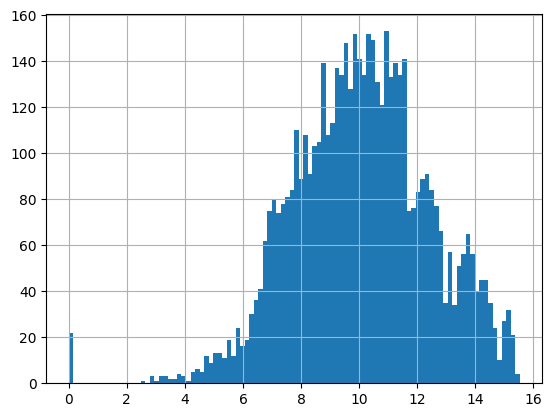

In [11]:
pd.concat([load_data(country, log_transform=True)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)

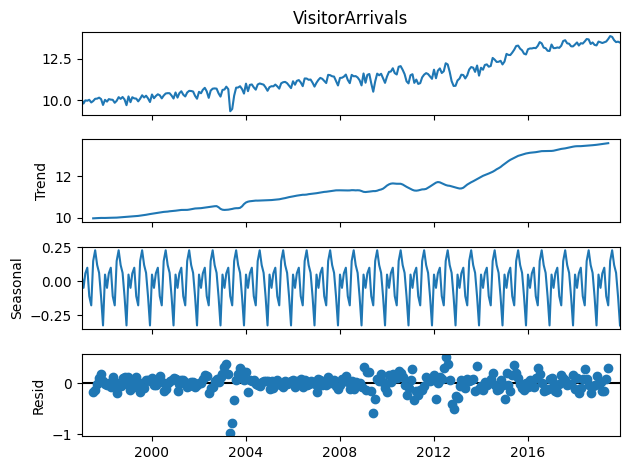

In [12]:
res = seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12)
fig = res.plot()

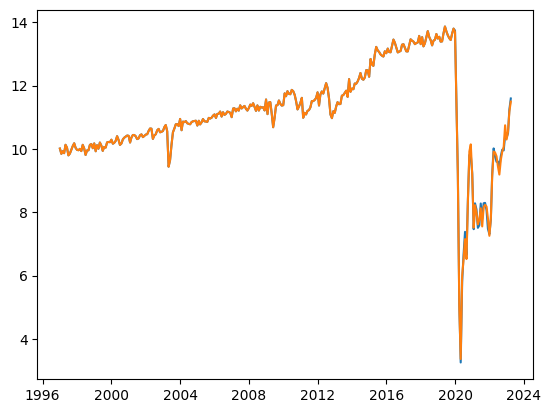

In [13]:
seasonal_component = pd.concat([res.seasonal, pd.Series(np.resize(res.seasonal.values[-12:], len(df['VisitorArrivals'].dropna()) - len(res.seasonal)))], ignore_index=True)
seasonal_component.index = df['VisitorArrivals'].dropna().index
seasonal_component[seasonal_component.index >= '2020-01-01'] = 0 # no seasonality during covid
# ax = plt.axes()
# (df['VisitorArrivals'].dropna() - seasonal_component).plot(ax=ax)
plt.plot(seasonal_component.index, df['VisitorArrivals'].dropna() - seasonal_component, label='no season')
seasonal_component = pd.concat([res.seasonal, pd.Series(np.resize(res.seasonal.values[-12:], len(df['VisitorArrivals'].dropna()) - len(res.seasonal)))], ignore_index=True)
seasonal_component.index = df['VisitorArrivals'].dropna().index
# seasonal_component[seasonal_component.index >= '2020-01-01'] = 0
# (df['VisitorArrivals'].dropna() - seasonal_component).plot(ax=ax)
plt.plot(seasonal_component.index, df['VisitorArrivals'].dropna() - seasonal_component, label='season')


In [14]:
def get_seasonal_component(seasonal_res, target_length):
    if len(seasonal_res.seasonal) >= target_length:
        return seasonal_res.seasonal.iloc[:target_length]
    seasonal_component = pd.concat([seasonal_res.seasonal, pd.Series(np.resize(seasonal_res.seasonal.values[-12:], target_length - len(seasonal_res.seasonal)))], ignore_index=True)
    return seasonal_component

#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove_covid=False):
    all_data = {country: load_data(country) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < ('2019-06-01' if country in ['Chinese Taipei', 'Hong Kong SAR'] else '2020-01-01')]['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            seasonal_component[(seasonal_component.index >= '2020-01-01') & (seasonal_component.index <= '2023-01-01')] = 0 # no seasonality during covid

            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

def inverse_target(target, seasonal_component, scaler):
    target = np.asarray(target)
    if target.ndim == 1:
        target = np.expand_dims(target, -1)
    return np.expm1(scaler.inverse_transform(target).flatten() + seasonal_component)

In [15]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove_covid=False)

<Axes: xlabel='Date'>

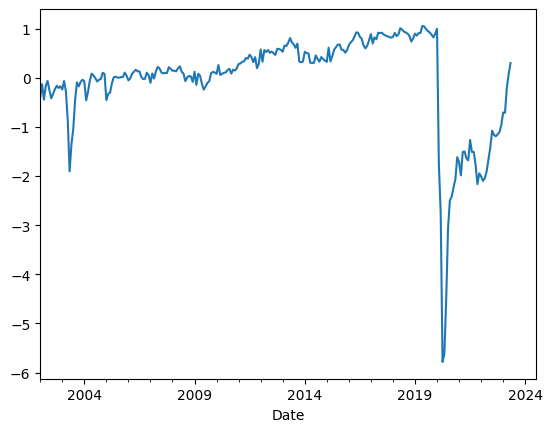

In [16]:
country = 'Singapore'
all_data[country]['VisitorArrivals'].plot()

In [17]:
all_data[country]

FXAgainstChina  CovidCases  CovidDeaths       FSI  GDPPerCap  \
Date                                                                       
2002-01-01       -0.266353   -0.148835    -0.165938 -0.749459  -1.885949   
2002-02-01       -0.266356   -0.148835    -0.165938 -0.749459  -1.866541   
2002-03-01       -0.266357   -0.148835    -0.165938 -0.749459  -1.847133   
2002-04-01       -0.266357   -0.148835    -0.165938 -0.749459  -1.827726   
2002-05-01       -0.266368   -0.148835    -0.165938 -0.749459  -1.808318   
...                    ...         ...          ...       ...        ...   
2024-03-01       -0.266473   -0.148835    -0.165938 -1.118897   2.579476   
2024-04-01       -0.266475   -0.148835    -0.165938 -1.118897   2.592414   
2024-05-01       -0.266479   -0.148835    -0.165938 -1.118897   2.605353   
2024-06-01       -0.266481   -0.148835    -0.165938 -1.118897   2.618291   
2024-07-01       -0.266481   -0.148835    -0.165938 -1.118897   2.631230   

                 GDP  Population  TravelPolicy  Temperature  Precipitation  \
Date                                                                         
2002-01-01 -1.704216   -1.735141     -0.316123    -0.940617      -0.350666   
2002-02-01 -1.693843   -1.731800     -0.316123    -0.117577      -1.445275   
2002-03-01 -1.683470   -1.728458     -0.316123     1.034679      -0.885383   
2002-04-01 -1.673096   -1.725117     -0.316123     1.363894      -0.319449   
2002-05-01 -1.662723   -1.721777     -0.316123     1.857718      -0.112007   
...              ...         ...           ...          ...            ...   
2024-03-01  2.348055    1.396152     -0.316123     0.268178      -0.025227   
2024-04-01  2.360815    1.401951     -0.316123     0.680052       0.061778   
2024-05-01  2.373575    1.407752     -0.316123     0.988536      -0.171378   
2024-06-01  2.386335    1.413551     -0.316123     0.569225      -0.461954   
2024-07-01  2.399095    1.419352     -0.316123     0.072226      -0.437463   

            ...  ChinaMovementPolicy  ChinaGDPPerCap  ChinaGDP  \
Date        ...                                                  
2002-01-01  ...             -0.33782       -1.222425 -1.207610   
2002-02-01  ...             -0.33782       -1.215993 -1.201527   
2002-03-01  ...             -0.33782       -1.209561 -1.195444   
2002-04-01  ...             -0.33782       -1.203130 -1.189361   
2002-05-01  ...             -0.33782       -1.196698 -1.183278   
...         ...                  ...             ...       ...   
2024-03-01  ...             -0.33782        2.152526  2.198065   
2024-04-01  ...             -0.33782        2.170200  2.216107   
2024-05-01  ...             -0.33782        2.187874  2.234149   
2024-06-01  ...             -0.33782        2.205549  2.252191   
2024-07-01  ...             -0.33782        2.223223  2.270233   

            VisitorArrivals  Popularity    Unrest  TravelRestriction  \
Date                                                                   
2002-01-01        -0.387516    0.675429 -0.195193           -0.33693   
2002-02-01        -0.128738    0.675429 -0.195193           -0.33693   
2002-03-01        -0.443118    0.675429 -0.195193           -0.33693   
2002-04-01        -0.167181    0.675429 -0.195193           -0.33693   
2002-05-01        -0.063039    0.675429 -0.195193           -0.33693   
...                     ...         ...       ...                ...   
2024-03-01              NaN    0.675429 -0.195193           -0.33693   
2024-04-01              NaN    0.675429 -0.195193           -0.33693   
2024-05-01              NaN    0.675429 -0.195193           -0.33693   
2024-06-01              NaN    0.675429 -0.195193           -0.33693   
2024-07-01              NaN    0.675429 -0.195193           -0.33693   

                Year  MonthSin  MonthCos  
Date                                      
2002-01-01 -1.083724 -0.010353  1.404845  
2002-02-01 -1.083724  0.696965  1.215416  
2002-03-01 -1.083724  1.214759  0.697883

In [18]:
# longest input sequence
np.unique([df['VisitorArrivals'].notna().sum() for country, df in all_data.items()], return_counts=True)

(array([125, 133, 135, 179, 217, 241, 245, 256, 257, 278, 292, 293, 301,
        306, 316, 325, 341, 412, 413]),
 array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [19]:
# longest required forecast is 18 months
np.unique([df['VisitorArrivals'].isna().sum() for country, df in all_data.items()], return_counts=True)

(array([13, 14, 15, 16, 17, 18]), array([1, 8, 5, 1, 1, 4]))

## Regression

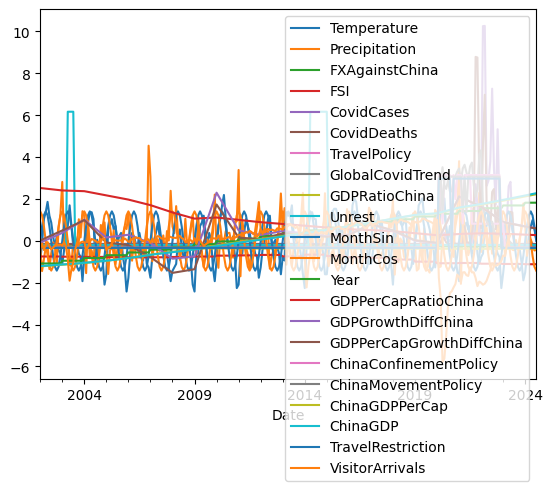

Pearson: -0.044980982924680606
Kendall: 0.07626542385806893
Spearman: 0.11308494943521982


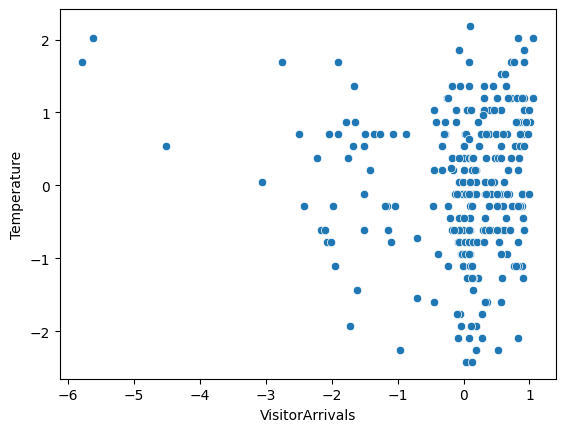

Pearson: -0.08750732431976796
Kendall: -0.07275657206359834
Spearman: -0.11106942064151694


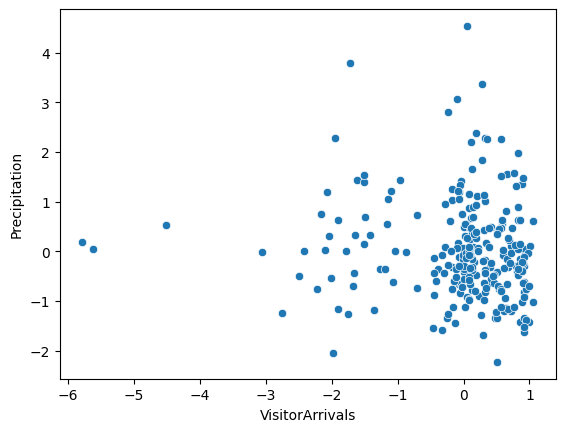

Pearson: -0.058982872733091454
Kendall: -0.12217476555955233
Spearman: -0.17487179024943403


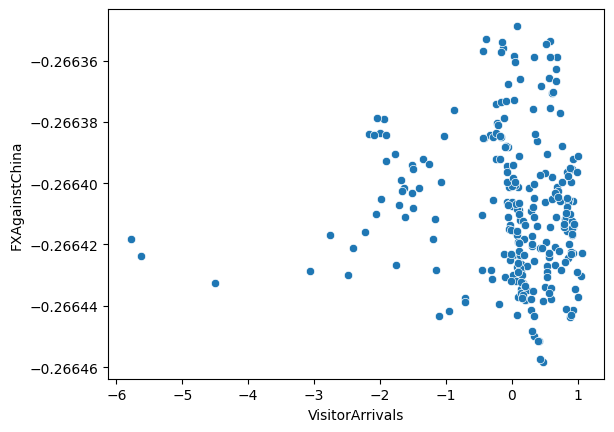

Pearson: 0.5587838019344611
Kendall: 0.12848537804865426
Spearman: 0.22040512264199794


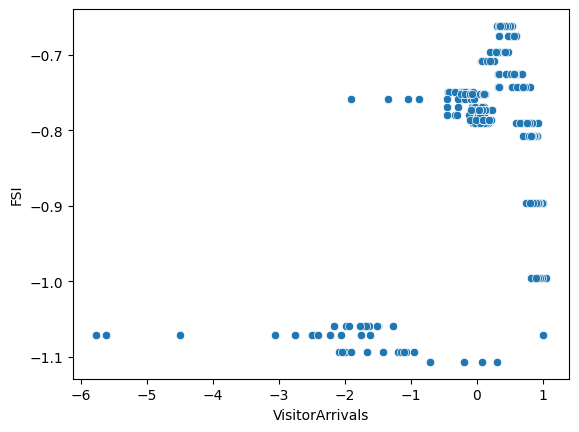

Pearson: -0.3350945259784057
Kendall: -0.4571233485901732
Spearman: -0.5873097219144569


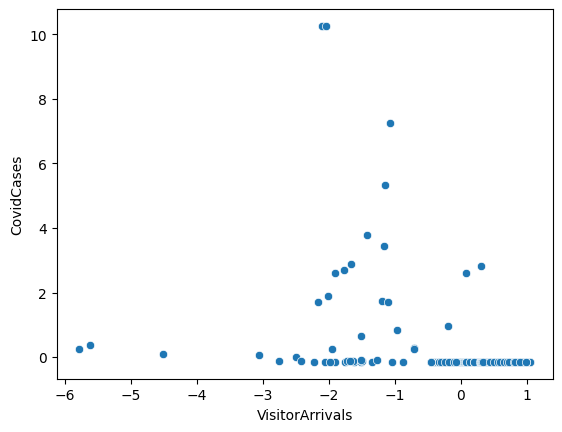

Pearson: -0.34905169703700967
Kendall: -0.40153922523770647
Spearman: -0.5062685551998471


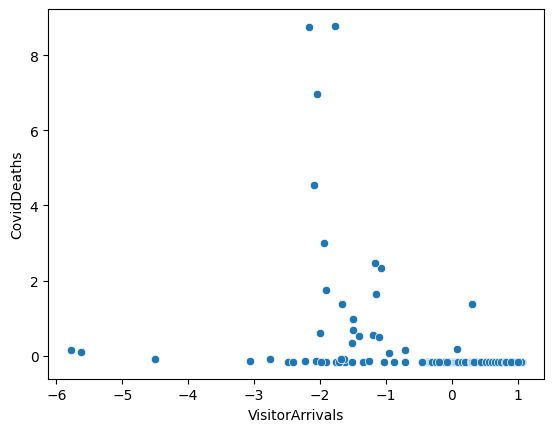

Pearson: -0.7998636995171495
Kendall: -0.4890963686285126
Spearman: -0.5966616813803745


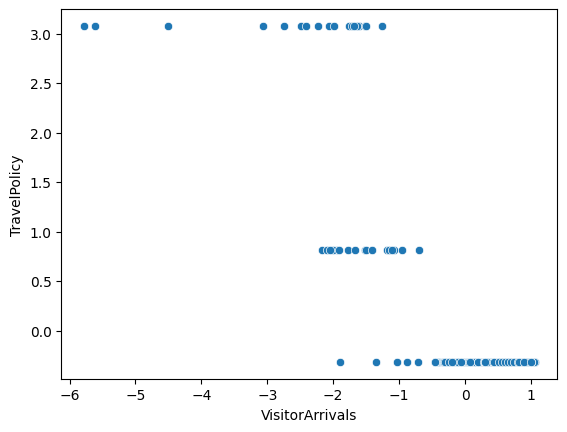

Pearson: -0.7754458913324651
Kendall: -0.4824255300088469
Spearman: -0.5986964561615755


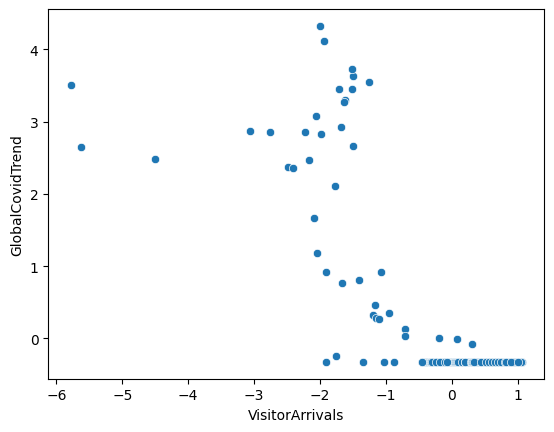

Pearson: 0.07262134702251866
Kendall: -0.30933852140077817
Spearman: -0.2558853553977015


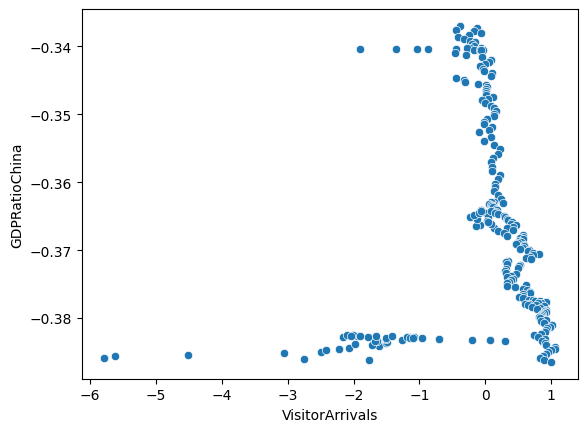

Pearson: -0.0187135268369965
Kendall: -0.01001998713986093
Spearman: -0.012248121964897657


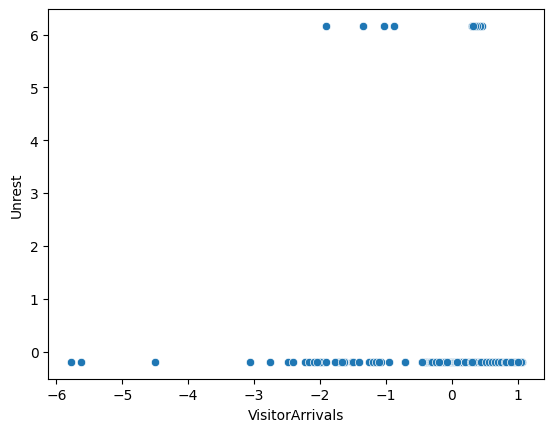

Pearson: -0.0660620615969902
Kendall: -0.002011848619936002
Spearman: -0.0015624149591256682


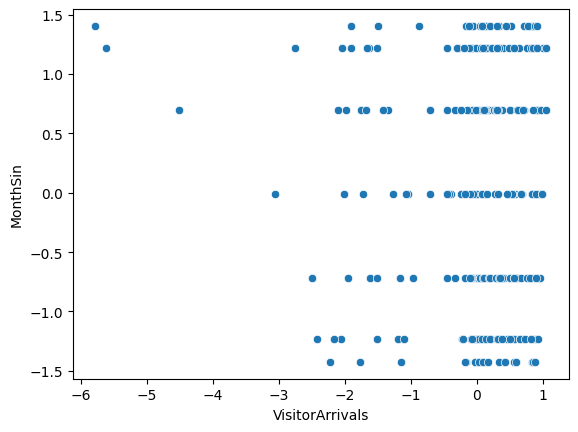

Pearson: 0.019415304215081208
Kendall: -0.023735418151461577
Spearman: -0.03342163896611458


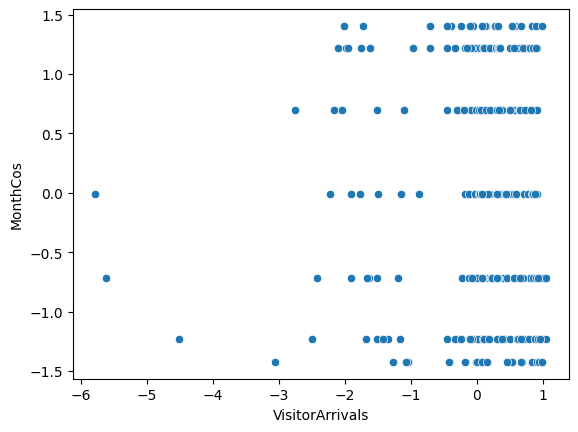

Pearson: -0.18459078079559987
Kendall: 0.3188524952348615
Spearman: 0.2056438385040606


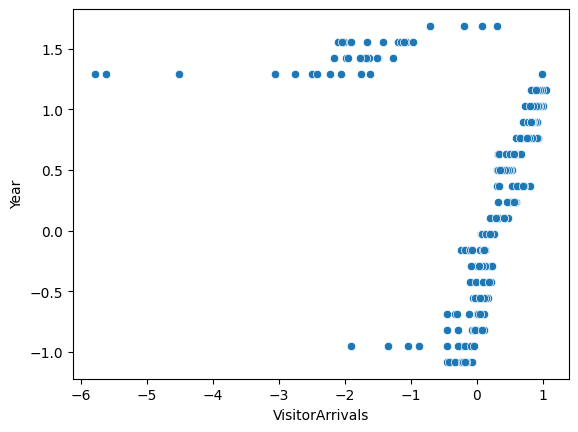

Pearson: 0.03013285103955461
Kendall: -0.31560068093385213
Spearman: -0.2486999196905257


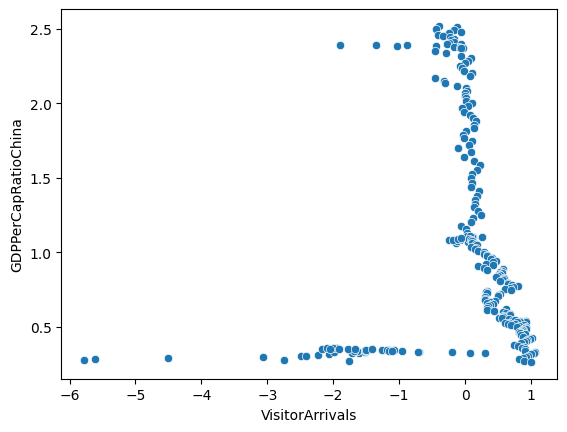

Pearson: -0.41885117224727036
Kendall: -0.18172422178988326
Spearman: -0.2945986222966247


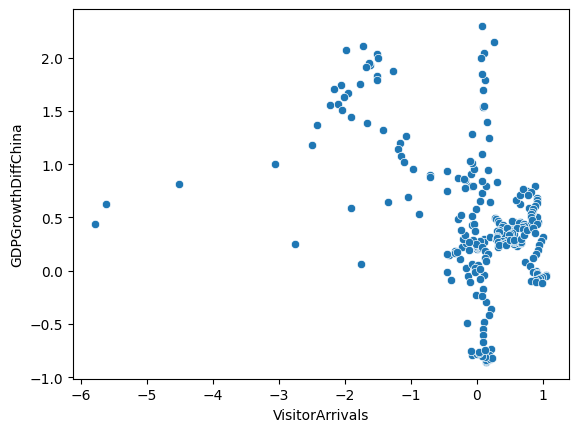

Pearson: -0.39209804327782416
Kendall: -0.15375729571984434
Spearman: -0.263032615826622


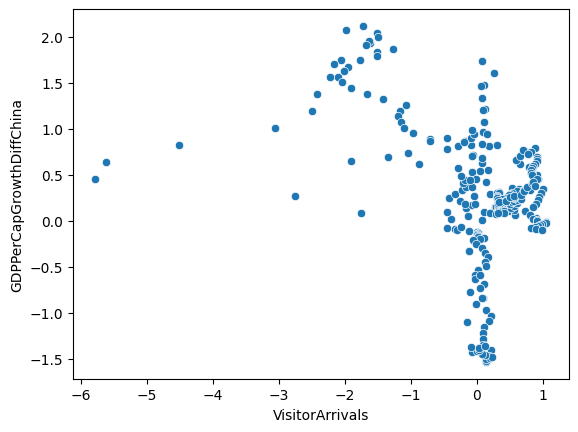

Pearson: -0.7570463481465954
Kendall: -0.47543503963421424
Spearman: -0.5843728822887924


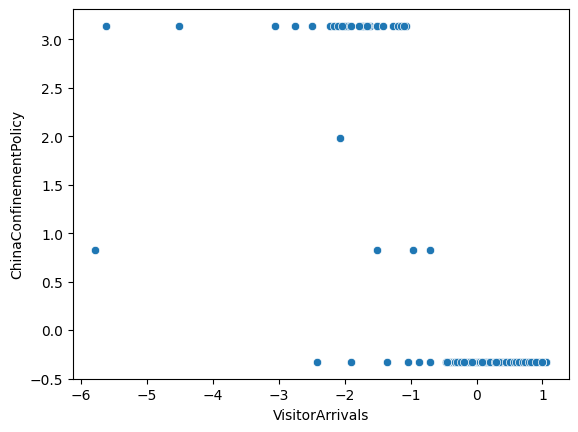

Pearson: -0.7817398143587403
Kendall: -0.47345676161391503
Spearman: -0.5825413293527986


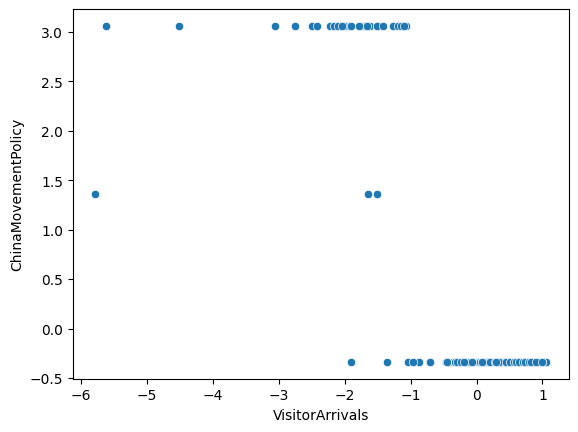

Pearson: -0.20533052489164477
Kendall: 0.3166342412451361
Spearman: 0.2059259343045878


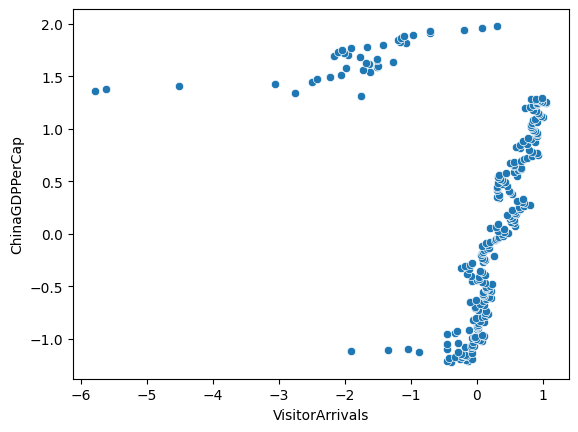

Pearson: -0.21410418999345218
Kendall: 0.3166342412451361
Spearman: 0.2059259343045878


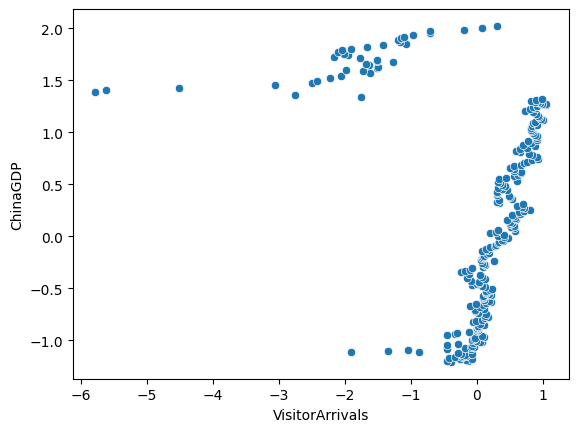

Pearson: -0.7900780590681825
Kendall: -0.46749288198704175
Spearman: -0.5714488208792518


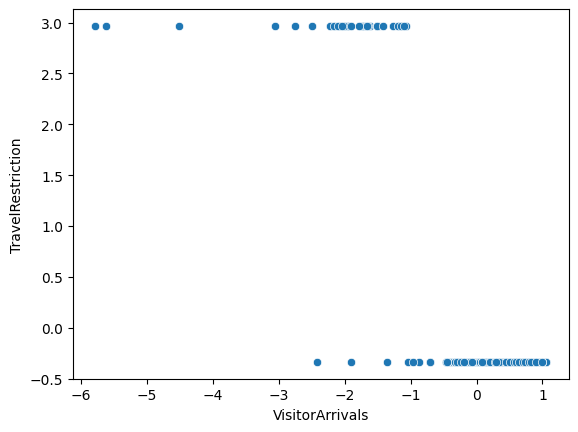

In [20]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
target = 'VisitorArrivals'
all_data[country][country_feat + universal_feat + [target]].plot()
plt.show()
for candidate in country_feat + universal_feat:
    print('Pearson:', all_data[country][target].corr(all_data[country][candidate]))
    print('Kendall:', all_data[country][target].corr(all_data[country][candidate], method='kendall'))
    print('Spearman:', all_data[country][target].corr(all_data[country][candidate], method='spearman'))
    sns.scatterplot(all_data[country], x=target, y=candidate)
    plt.show()

In [21]:
# repeat for all countries
reg_pred, all_y = [], []
for country, df in all_data.items():
    print('processing', country)
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_mae = grid_search_ml(train_x, train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
                                           additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                              'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                              'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
    print(best_param, best_mae)
    model = get_model(best_param[0])
    model = model.set_params(**best_param[2])
    scaler = get_scaler(best_param[1])
    train_x_ = scaler.fit_transform(train_x)
    test_x_ = scaler.transform(test_x)
    model.fit(train_x_, train_y,)# sample_weight=sample_weight)
    pred = model.predict(test_x_)
    
    reg_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                   y_scaler if single_y_scaler else y_scaler[country]))
    all_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                y_scaler if single_y_scaler else y_scaler[country]))
    
reg_pred, all_y = np.concatenate(reg_pred), np.concatenate(all_y)

processing Canada
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.5840114021701239
processing Chile
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.5338786217263733
processing Mexico
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None

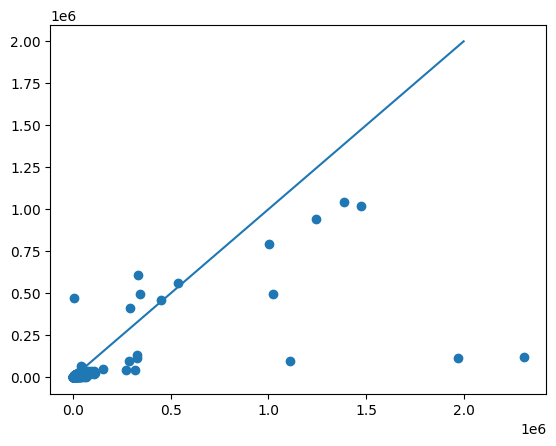

In [22]:
plt.scatter(all_y, reg_pred)
plt.plot((0, 2000000), (0, 2000000))

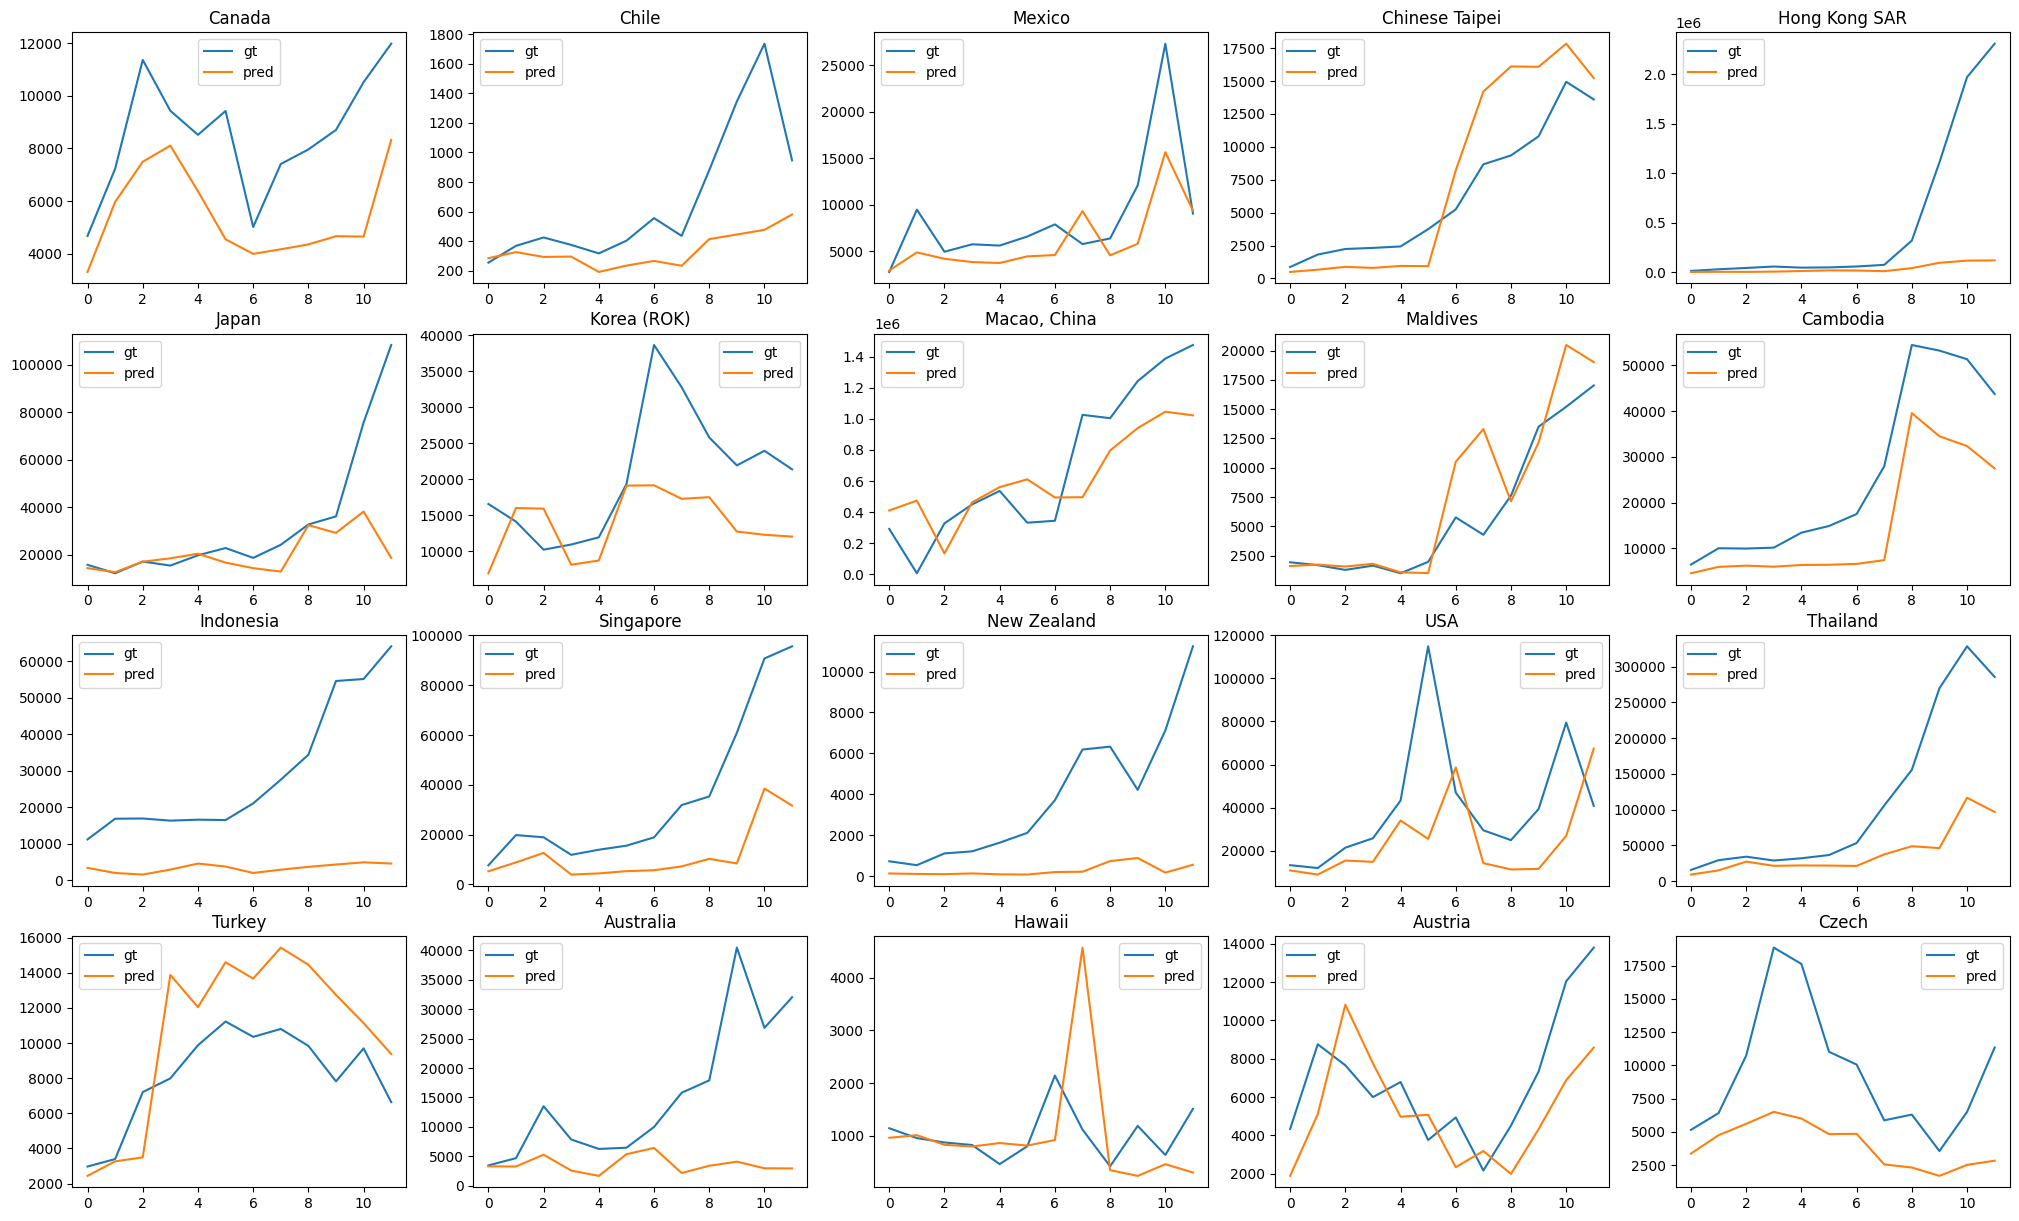

In [23]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [24]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
reg_mae = mean_absolute_error(all_y, reg_pred)
reg_mape = mean_absolute_percentage_error(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}\nBaseline Model MAE: {reg_mae:.5f}\nBaseline Model MAPE: {reg_mape:.5f}')

Baseline Model RMSE: 210710.11083
Baseline Model R2: 0.41137
Baseline Model MAE: 47136.41237
Baseline Model MAPE: 0.76469


## Combination Regression Model

In [25]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'DistFromChina', 'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']

In [26]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)
# best_param, best_mae = grid_search_ml(all_train_x, all_train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
#                                        additional_params={'rf': [{'n_estimators': n} for n in (10, 25, 50, 100)],
#                                                           'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
#                                                           'xgb': [{'n_estimators': n} for n in (10, 25, 50, 100)]})

In [27]:
best_param, best_mae = ('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 500}), 0.14475667605963807
print(best_param, best_mae)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x_ = scaler.fit_transform(all_train_x)
model.fit(all_train_x_, all_train_y,)# sample_weight=sample_weight)

reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = model.predict(test_x_)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 500}) 0.14475667605963807


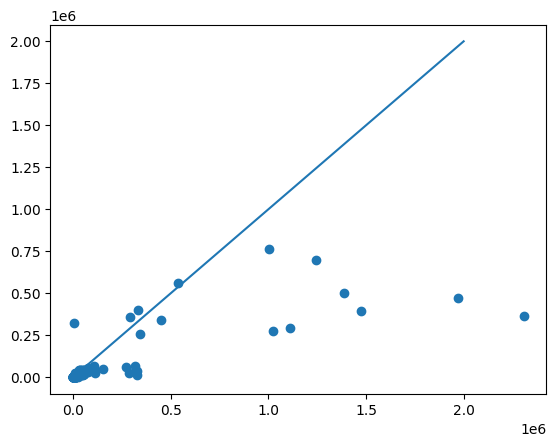

In [28]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 2000000), (0, 2000000))

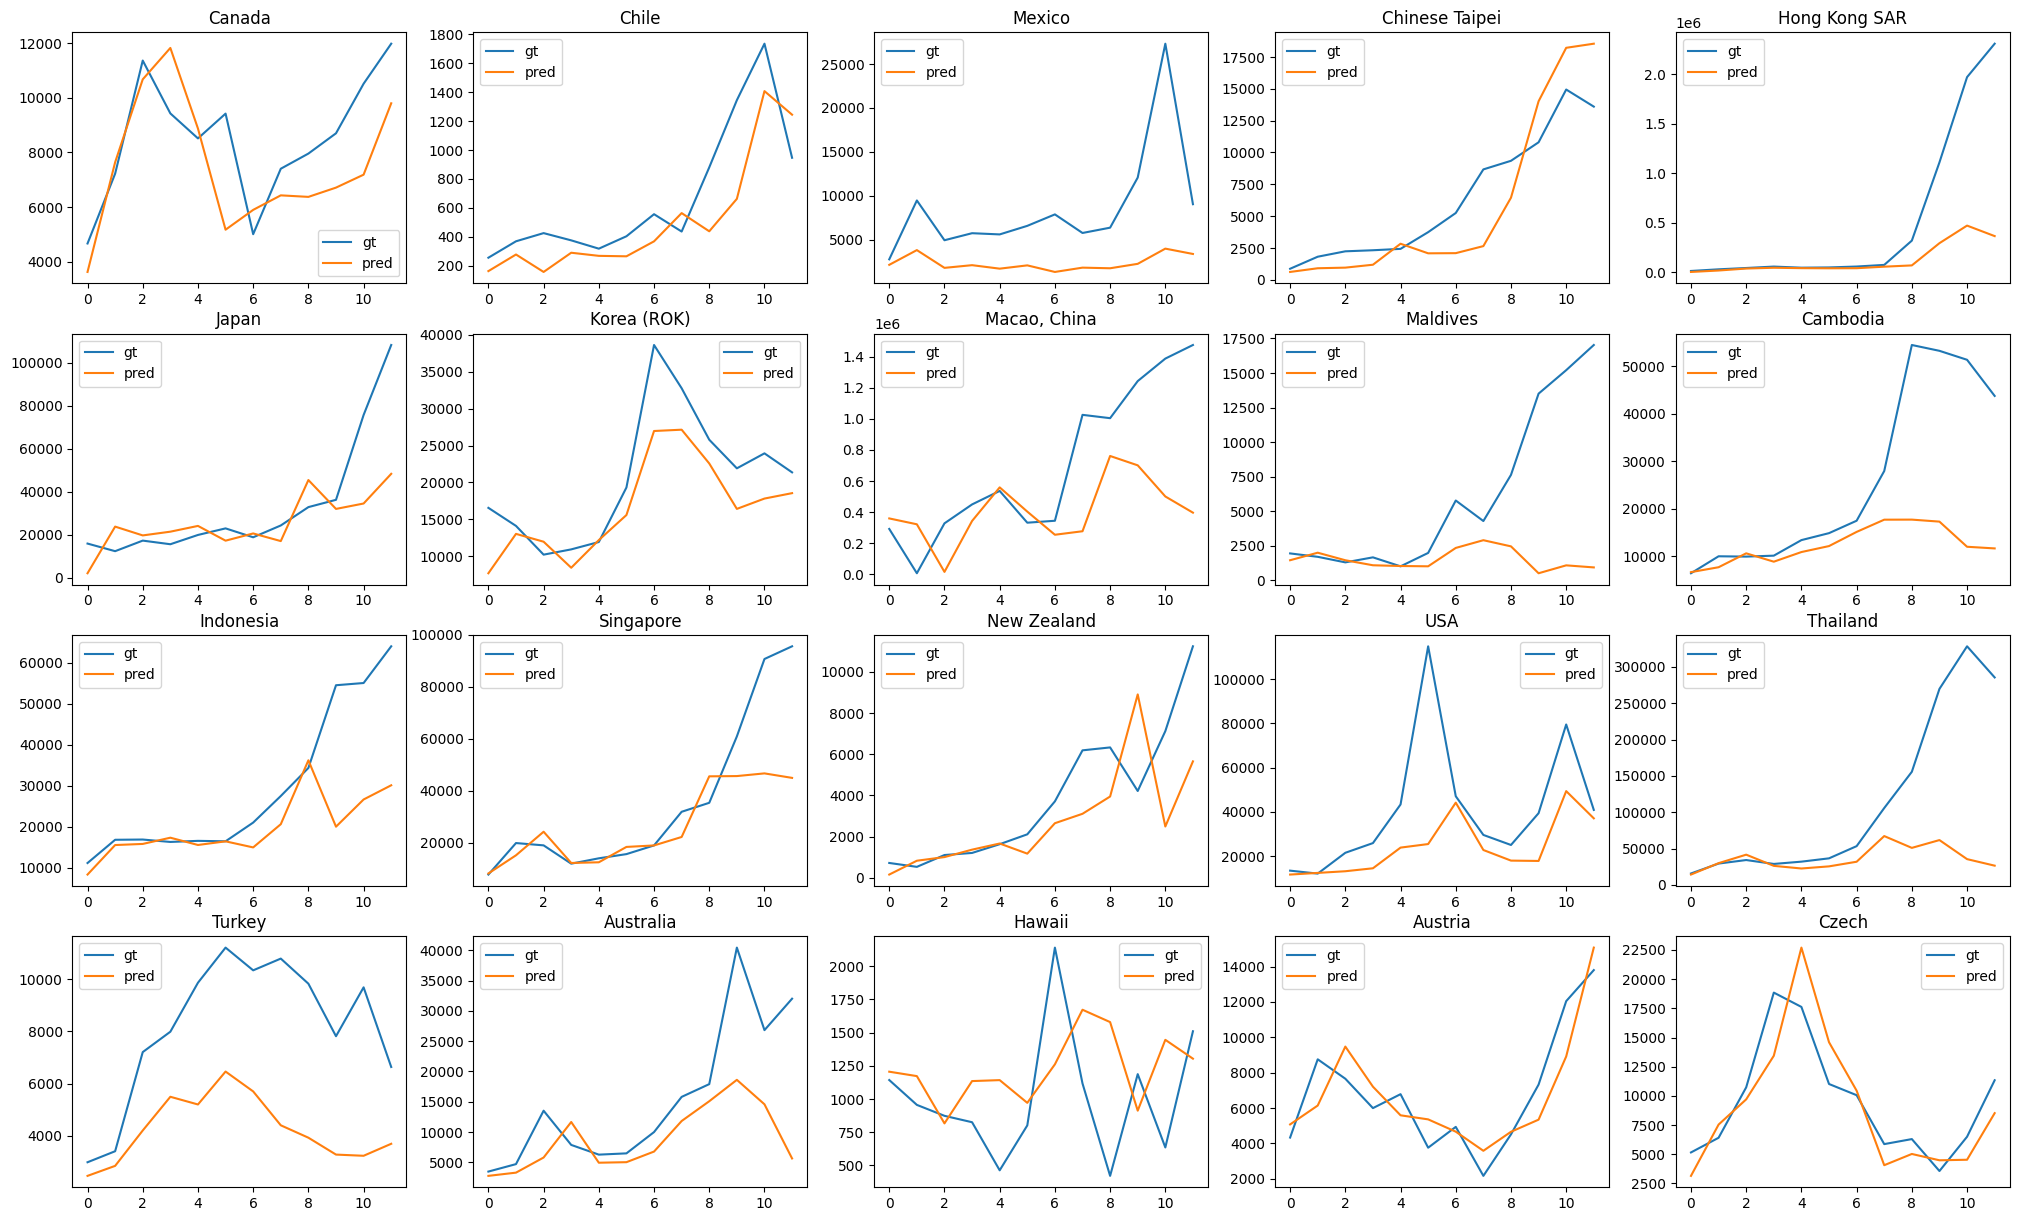

In [29]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [30]:
(all_y == all_comb_y).all()

True

In [31]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}')

Combination Model RMSE: 204945.32968
Combination Model R2: 0.44314
Combination Model MAE: 47010.53497
Combination Model MAPE: 0.55078


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

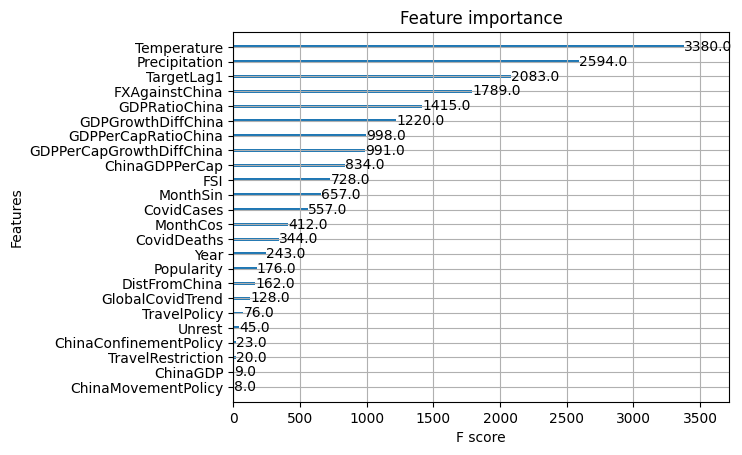

In [32]:
from xgboost import plot_importance
plot_importance(model)

In [33]:
# auto regressive predictions
reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = []
    for i in range(len(test_x_)):
        if i > 0:
            test_x_.iloc[i:i+1, test_x_.columns.get_loc('TargetLag1')] = last_pred
        last_pred = model.predict(test_x_.iloc[i:i+1])
        pred.append(last_pred[0])
        
    pred = np.asarray(pred)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

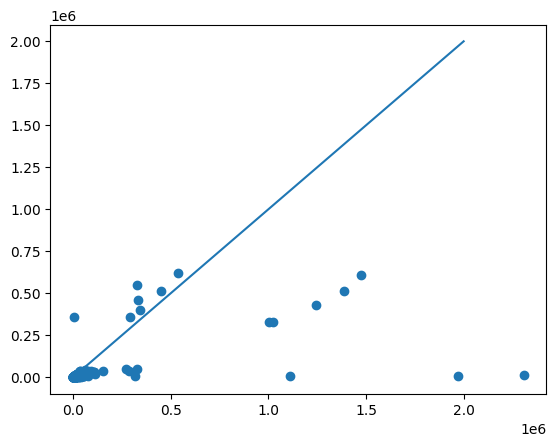

In [34]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 2000000), (0, 2000000))

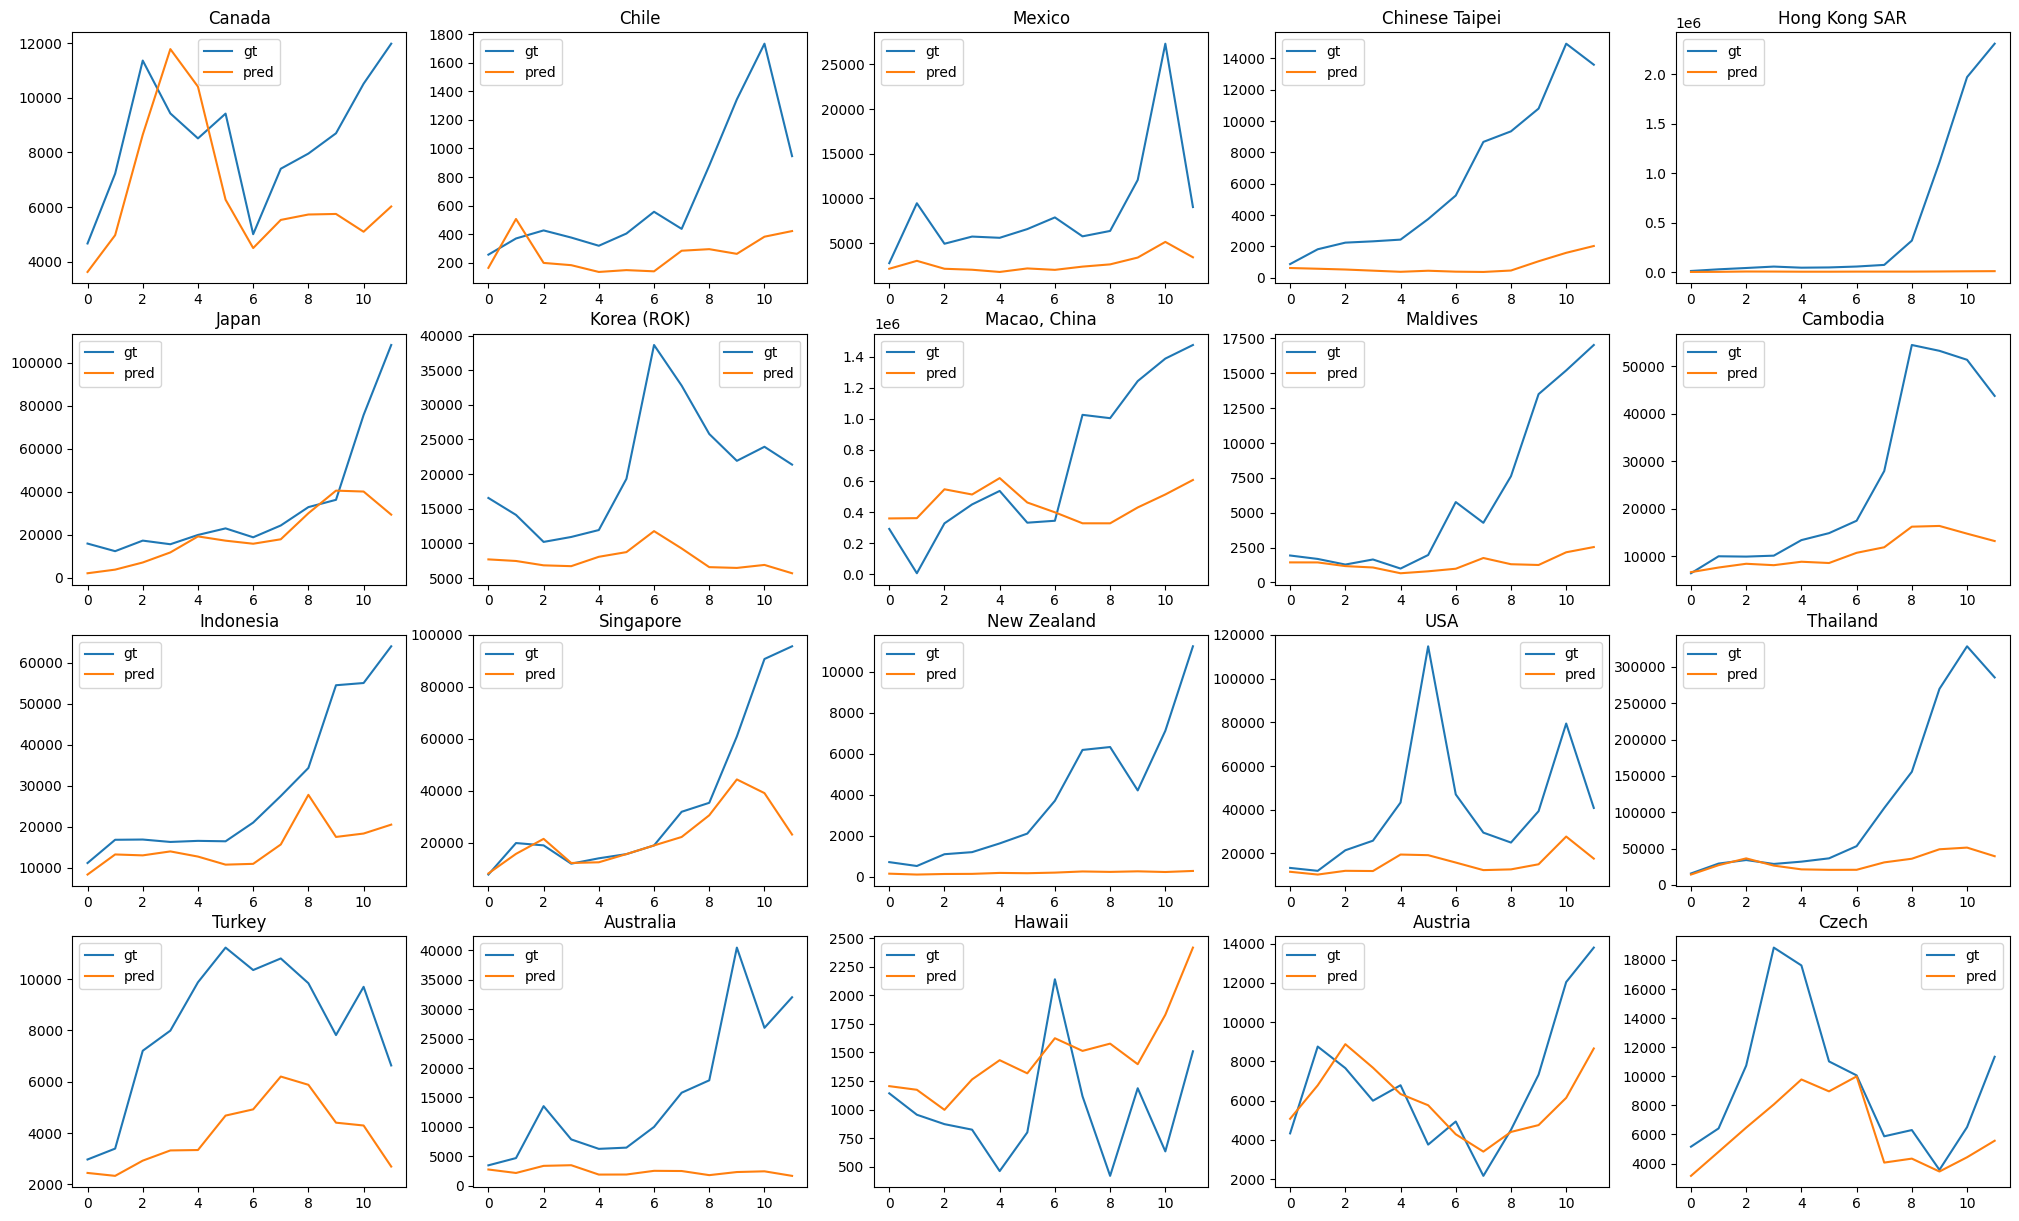

In [35]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [36]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}')

Combination Model RMSE: 241813.21109
Combination Model R2: 0.22476
Combination Model MAE: 56673.15884
Combination Model MAPE: 0.73122


# RNN

In [37]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1):
    df = df.copy().dropna()
    x, y = [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2
    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
    y = np.asarray(y)
    return x[:-test_size*output_len], y[:-test_size*output_len], x[-test_size:], y[-test_size:] # train is until test_size*output_len to prevent leaking of test data to train data

In [38]:
seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data['Australia'], input_len=24, output_len=1, test_size=12)

In [39]:
len(country_feat + universal_feat)

23

In [40]:
seq_test_x[-1]

Temperature  Precipitation  FXAgainstChina       FSI    Country  \
Date                                                                          
2021-04-01     0.005316      -0.577146       -0.266425 -1.265155  Australia   
2021-05-01    -0.738973      -0.580407       -0.266421 -1.265155  Australia   
2021-06-01    -1.419467      -0.489125       -0.266411 -1.265155  Australia   
2021-07-01    -1.334405      -0.606487       -0.266397 -1.265155  Australia   
2021-08-01    -1.036689      -0.880333       -0.266387 -1.265155  Australia   
2021-09-01    -0.441257      -0.922714       -0.266386 -1.265155  Australia   
2021-10-01     0.239236      -0.456524       -0.266391 -1.265155  Australia   
2021-11-01     0.494421       0.518237       -0.266379 -1.265155  Australia   
2021-12-01     1.196180       0.221571       -0.266363 -1.265155  Australia   
2022-01-01     1.387569       1.740763       -0.266363 -1.226641  Australia   
2022-02-01     1.068587       1.395196       -0.266361 -1.226641  Australia   
2022-03-01     1.004791       0.606259       -0.266380 -1.226641  Australia   
2022-04-01     0.260501      -0.123997       -0.266389 -1.226641  Australia   
2022-05-01    -0.653912      -0.127257       -0.266386 -1.226641  Australia   
2022-06-01    -1.376936      -0.746670       -0.266383 -1.226641  Australia   
2022-07-01    -1.695917      -0.648868       -0.266371 -1.226641  Australia   
2022-08-01    -1.164282      -0.626048       -0.266388 -1.226641  Australia   
2022-09-01    -0.505054      -0.599967       -0.266382 -1.226641  Australia   
2022-10-01     0.090378       0.149849       -0.266364 -1.226641  Australia   
2022-11-01     0.409359       0.107468       -0.266388 -1.226641  Australia   
2022-12-01     0.962260       0.498677       -0.266384 -1.226641  Australia   
2023-01-01     1.192713       1.616794       -0.266385 -1.256596  Australia   
2023-02-01     1.048997       1.568962       -0.266386 -1.256596  Australia   
2023-03-01     0.725534       0.800419       -0.266369 -1.256596  Australia   

            CovidCases  CovidDeaths  TravelPolicy  GlobalCovidTrend  \
Date                                                                  
2021-04-01   -0.097674    -0.116708      4.208439          3.628997   
2021-05-01   -0.099084    -0.129948      4.208439          3.274904   
2021-06-01   -0.095970    -0.129948      4.208439          2.920812   
2021-07-01   -0.079585    -0.010790      4.208439          3.555227   
2021-08-01    0.059264     0.545277      4.208439          3.735224   
2021-09-01    0.254788     2.074464      4.208439          2.669996   
2021-10-01    0.411550     3.080682      4.208439          2.106399   
2021-11-01    0.173650     1.928827      1.946158          2.463442   
2021-12-01    1.038361     1.630934      1.946158          4.115874   
2022-01-01   14.267787    13.857806      1.946158          4.325379   
2022-02-01    4.993315     9.991811      1.946158          1.666734   
2022-03-01    8.348653     4.245776      0.815018          1.179857   
2022-04-01    9.822234     7.191612      0.815018          0.914288   
2022-05-01   10.758045     9.429123      0.815018          0.760848   
2022-06-01    5.625576     9.309966      0.815018          0.811011   
2022-07-01    8.257166    14.367535     -0.316123          0.914288   
2022-08-01    5.642401    13.096523     -0.316123          0.456918   
2022-09-01    1.335522     4.543670     -0.316123          0.324134   
2022-10-01    1.115953     3.027723     -0.316123          0.288724   
2022-11-01    2.154714     3.570551     -0.316123          0.265118   
2022-12-01    2.981456     7.575563     -0.316123          0.353641   
2023-01-01    1.237697     8.224309     -0.316123          0.135284   
2023-02-01    0.420495     3.828726     -0.316123          0.029056   
2023-03-01    0.558499     1.902348     -0.316123         -0.000451   

            GDPRatioChina  ...  GDPPerCapRatioChina  GDPGrowthDiffChina  \
Date                       ...     

In [41]:
seq_test_y

array([[-0.62743124],
       [-0.36786176],
       [ 0.01468458],
       [-0.21928424],
       [-0.28818444],
       [-0.32201509],
       [-0.17053231],
       [ 0.08283894],
       [ 0.114423  ],
       [ 0.49144373],
       [ 0.47931705],
       [ 0.60476977]])

In [42]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=None)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [43]:
len(train_dataset) + len(val_dataset)

376

In [44]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mse', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [24]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori)
        for batch_size in param_grids.get('batch_size', [64, 128]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(1, 3)): # 2 layers result in worse performance
                    for hidden_size in param_grids.get('hidden_size', [20, 50, 75]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.001, 0.0005]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    # train_dataset.initialize_states()
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    # val_dataset.set_initial_states(train_dataset.get_initial_states())
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [45]:
# best_param, best_rmse = grid_search_rnn_custom(country_list)
# best_param, best_rmse

Epoch 0: train loss 0.5441, val loss 0.9321, time 1.8753
Epoch 1: train loss 0.3519, val loss 1.2958, time 1.4598
Epoch 2: train loss 0.3121, val loss 1.4566, time 1.4177
Epoch 3: train loss 0.3068, val loss 1.1627, time 1.4155
Epoch 4: train loss 0.3054, val loss 1.1895, time 1.4689
Epoch 5: train loss 0.2951, val loss 1.0241, time 1.4499
Epoch 6: train loss 0.3026, val loss 0.7632, time 1.4338
Epoch 7: train loss 0.2899, val loss 0.7029, time 1.4457
Epoch 8: train loss 0.2916, val loss 0.5993, time 1.4504
Epoch 9: train loss 0.2808, val loss 0.7985, time 1.4324
Epoch 10: train loss 0.2752, val loss 0.6693, time 1.4347
Epoch 11: train loss 0.2859, val loss 0.6339, time 1.4414
Epoch 12: train loss 0.2752, val loss 0.7848, time 1.4444
Epoch 13: train loss 0.2772, val loss 0.6228, time 1.4385
Early stopping as no improvement in val loss


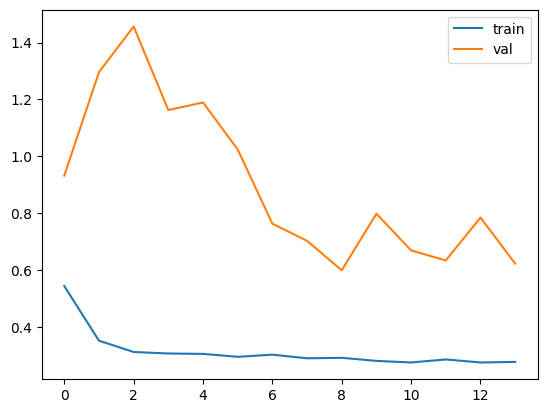

In [46]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.L1Loss()

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [47]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
# rnn_preds, rnn_gts = [], []
# for country in all_data.keys():
#     test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
#     preds = []
#     for i in range(len(test_x_)):
#         if i > 0:
#             last_pred = np.concatenate(preds)[-len(test_x_[i]):]
#             test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
#         init_state = model.get_embeddings([country])
#         x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
#         init_state, x_input = init_state.cuda(), x_input.cuda()
#         pred = model(x_input, init_state).detach().cpu().numpy()[0]
#         preds.append(pred)
        
#     preds = np.concatenate(preds)
#     gts = np.concatenate(test_y_)
#     rnn_preds.append(preds)
#     rnn_gts.append(gts)

# rnn_preds = np.asarray(rnn_preds)
# rnn_gts = np.asarray(rnn_gts)

In [48]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [49]:
(rnn_gt == all_y).all()

True

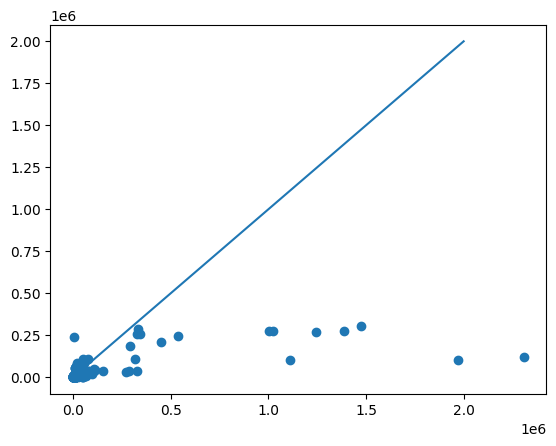

In [50]:
plt.scatter(all_y, rnn_pred)
plt.plot((0, 2000000), (0, 2000000))

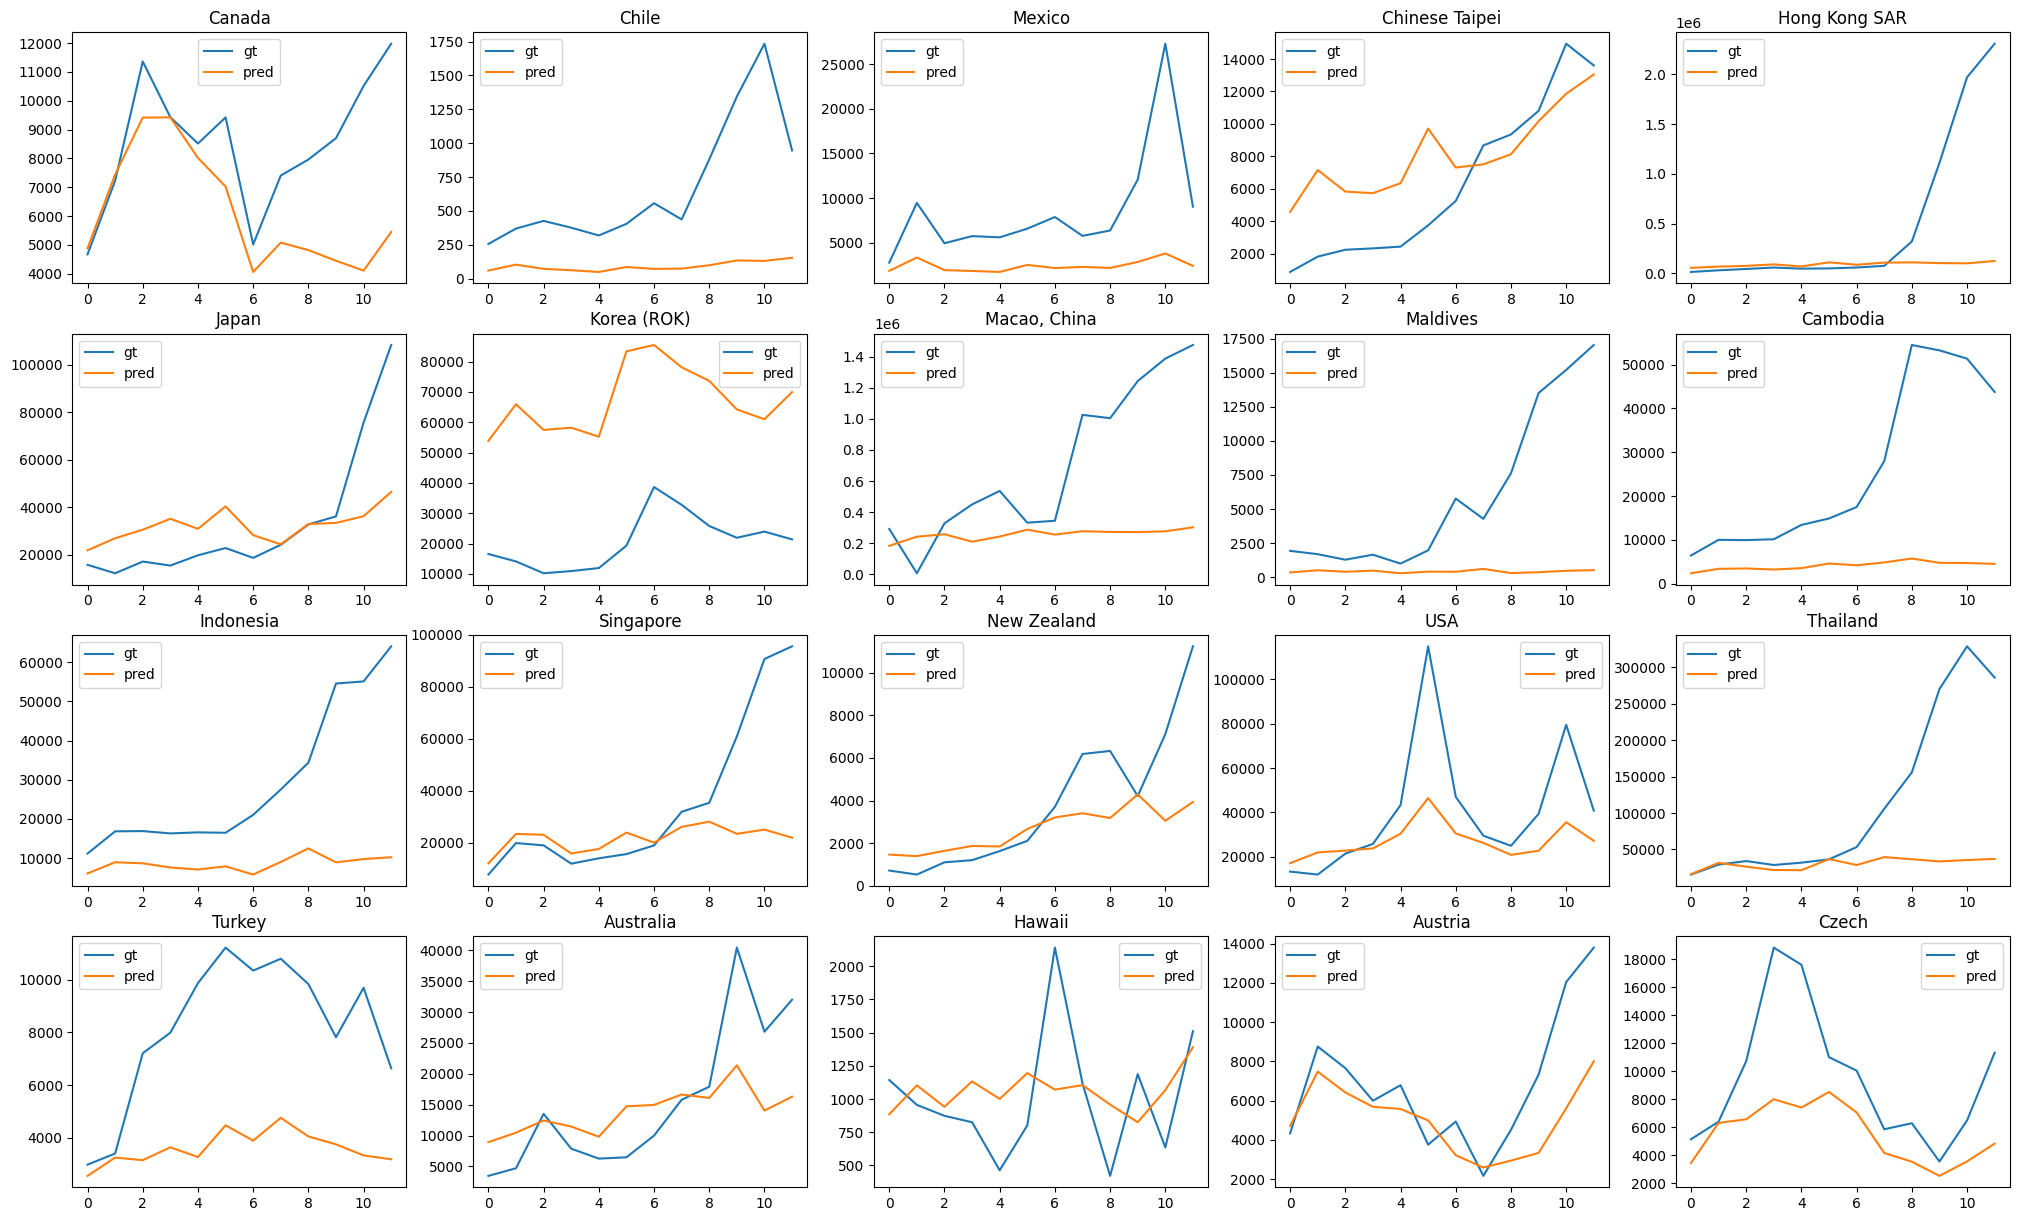

In [51]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [52]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}')

RNN RMSE: 245864.37470
RNN R2: 0.19857
RNN MAE: 60484.02089
RNN MAPE: 0.82192


# Separate RNN models

In [53]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 0.7883, val loss 0.5794, time 0.0902
Epoch 1: train loss 0.7484, val loss 0.5734, time 0.0777
Epoch 2: train loss 0.7877, val loss 0.5666, time 0.0743
Epoch 3: train loss 0.7395, val loss 0.5619, time 0.0756
Epoch 4: train loss 0.7535, val loss 0.5567, time 0.0759
Epoch 5: train loss 0.7206, val loss 0.5479, time 0.0866
Epoch 6: train loss 0.6729, val loss 0.5343, time 0.0980
Epoch 7: train loss 0.7254, val loss 0.5202, time 0.0762
Epoch 8: train loss 0.6330, val loss 0.5039, time 0.0743
Epoch 9: train loss 0.6215, val loss 0.4872, time 0.0760
Epoch 10: train loss 0.5409, val loss 0.4709, time 0.0754
Epoch 11: train loss 0.4995, val loss 0.4575, time 0.0745
Epoch 12: train loss 0.4716, val loss 0.4453, time 0.0754
Epoch 13: train loss 0.4543, val loss 0.4322, time 0.0758
Epoch 14: train loss 0.4148, val loss 0.4173, time 0.0811
Epoch 15: train loss 0.4164, val loss 0.4019, time 0.0745
Epoch 16: train loss 0.4067, val loss 0.3844, time 0.0898
Epoch 17: train l

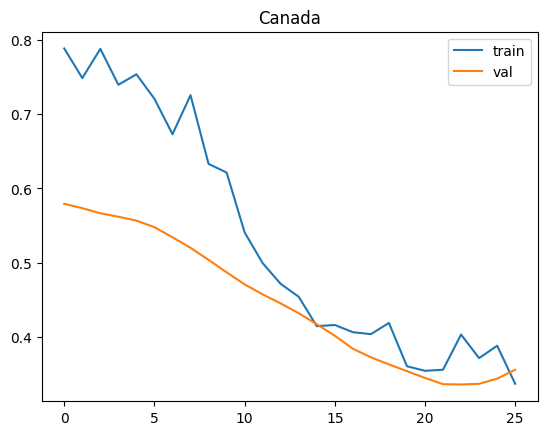

Chile
Epoch 0: train loss 0.7374, val loss 0.1792, time 0.0377
Epoch 1: train loss 0.8327, val loss 0.1789, time 0.0335
Epoch 2: train loss 0.7764, val loss 0.1806, time 0.0324
Epoch 3: train loss 0.7319, val loss 0.1802, time 0.0437
Epoch 4: train loss 0.7775, val loss 0.1807, time 0.0349
Epoch 5: train loss 0.7878, val loss 0.1811, time 0.0324
Epoch 6: train loss 0.7347, val loss 0.1807, time 0.0328
Epoch 7: train loss 0.7787, val loss 0.1817, time 0.0328
Epoch 8: train loss 0.7389, val loss 0.1832, time 0.0323
Epoch 9: train loss 0.7355, val loss 0.1859, time 0.0321
Epoch 10: train loss 0.6419, val loss 0.1900, time 0.0323
Epoch 11: train loss 0.6725, val loss 0.1925, time 0.0329
Epoch 12: train loss 0.7207, val loss 0.1961, time 0.0323
Epoch 13: train loss 0.6427, val loss 0.1986, time 0.0329
Early stopping as no improvement in val loss


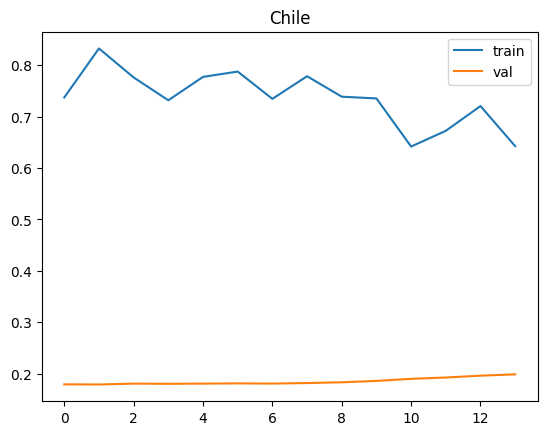

Mexico
Epoch 0: train loss 0.7943, val loss 0.8320, time 0.0678
Epoch 1: train loss 0.7791, val loss 0.8315, time 0.0595
Epoch 2: train loss 0.7789, val loss 0.8300, time 0.0608
Epoch 3: train loss 0.7825, val loss 0.8270, time 0.0604
Epoch 4: train loss 0.7713, val loss 0.8272, time 0.0611
Epoch 5: train loss 0.7586, val loss 0.8294, time 0.0608
Epoch 6: train loss 0.7430, val loss 0.8316, time 0.0604
Epoch 7: train loss 0.7357, val loss 0.8319, time 0.0601
Epoch 8: train loss 0.7154, val loss 0.8344, time 0.0605
Epoch 9: train loss 0.7008, val loss 0.8402, time 0.0601
Epoch 10: train loss 0.6765, val loss 0.8489, time 0.0601
Epoch 11: train loss 0.6510, val loss 0.8590, time 0.0613
Epoch 12: train loss 0.6169, val loss 0.8697, time 0.0611
Epoch 13: train loss 0.5904, val loss 0.8834, time 0.0647
Early stopping as no improvement in val loss


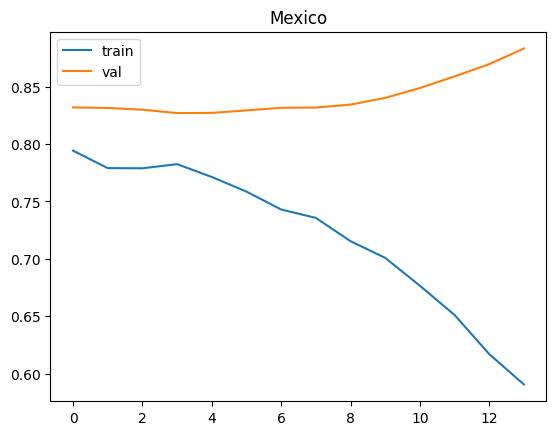

Chinese Taipei
Epoch 0: train loss 0.9676, val loss 1.4445, time 0.0558
Epoch 1: train loss 0.6889, val loss 1.4393, time 0.0497
Epoch 2: train loss 0.7890, val loss 1.4341, time 0.0493
Epoch 3: train loss 0.7111, val loss 1.4282, time 0.0493
Epoch 4: train loss 0.6885, val loss 1.4202, time 0.0488
Epoch 5: train loss 0.6373, val loss 1.4112, time 0.0500
Epoch 6: train loss 0.6023, val loss 1.4014, time 0.0490
Epoch 7: train loss 0.7045, val loss 1.3878, time 0.0498
Epoch 8: train loss 0.6902, val loss 1.3768, time 0.0480
Epoch 9: train loss 0.5215, val loss 1.3692, time 0.0482
Epoch 10: train loss 0.4681, val loss 1.3610, time 0.0491
Epoch 11: train loss 0.6058, val loss 1.3536, time 0.0481
Epoch 12: train loss 0.5755, val loss 1.3470, time 0.0502
Epoch 13: train loss 0.4130, val loss 1.3394, time 0.0560
Epoch 14: train loss 0.3925, val loss 1.3311, time 0.0523
Epoch 15: train loss 0.3910, val loss 1.3220, time 0.0486
Epoch 16: train loss 0.3973, val loss 1.3119, time 0.0533
Epoch 17:

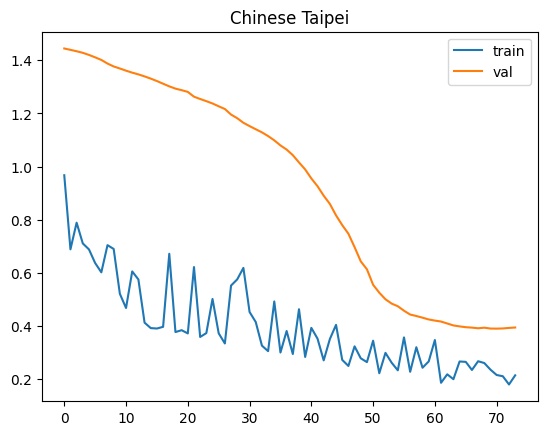

Hong Kong SAR
Epoch 0: train loss 0.6619, val loss 1.3163, time 0.1162
Epoch 1: train loss 0.6546, val loss 1.3051, time 0.0847
Epoch 2: train loss 0.6381, val loss 1.2914, time 0.0877
Epoch 3: train loss 0.6270, val loss 1.2740, time 0.0889
Epoch 4: train loss 0.6100, val loss 1.2580, time 0.0863
Epoch 5: train loss 0.5832, val loss 1.2424, time 0.0857
Epoch 6: train loss 0.5604, val loss 1.2267, time 0.0864
Epoch 7: train loss 0.5201, val loss 1.2099, time 0.0859
Epoch 8: train loss 0.4912, val loss 1.1896, time 0.0873
Epoch 9: train loss 0.4556, val loss 1.1738, time 0.0872
Epoch 10: train loss 0.4266, val loss 1.1537, time 0.0863
Epoch 11: train loss 0.4003, val loss 1.1350, time 0.0868
Epoch 12: train loss 0.3837, val loss 1.1103, time 0.0872
Epoch 13: train loss 0.3704, val loss 1.0849, time 0.0871
Epoch 14: train loss 0.3638, val loss 1.0606, time 0.0878
Epoch 15: train loss 0.3513, val loss 1.0376, time 0.0870
Epoch 16: train loss 0.3413, val loss 1.0116, time 0.0857
Epoch 17: 

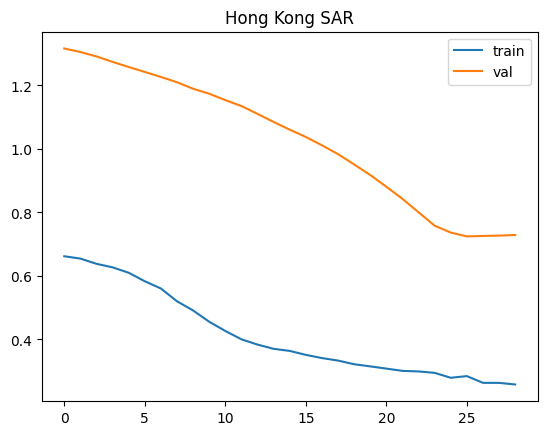

Japan
Epoch 0: train loss 0.6981, val loss 0.6648, time 0.1134
Epoch 1: train loss 0.7125, val loss 0.6516, time 0.0997
Epoch 2: train loss 0.6493, val loss 0.6379, time 0.1060
Epoch 3: train loss 0.6428, val loss 0.6222, time 0.0939
Epoch 4: train loss 0.6322, val loss 0.6050, time 0.0933
Epoch 5: train loss 0.6462, val loss 0.5917, time 0.0948
Epoch 6: train loss 0.5643, val loss 0.5815, time 0.0935
Epoch 7: train loss 0.5518, val loss 0.5696, time 0.0936
Epoch 8: train loss 0.5868, val loss 0.5540, time 0.0942
Epoch 9: train loss 0.4735, val loss 0.5414, time 0.0940
Epoch 10: train loss 0.5019, val loss 0.5273, time 0.0935
Epoch 11: train loss 0.4601, val loss 0.5178, time 0.0969
Epoch 12: train loss 0.4767, val loss 0.5088, time 0.0952
Epoch 13: train loss 0.4286, val loss 0.4979, time 0.0950
Epoch 14: train loss 0.4328, val loss 0.4864, time 0.0933
Epoch 15: train loss 0.3799, val loss 0.4807, time 0.0914
Epoch 16: train loss 0.3437, val loss 0.4770, time 0.0912
Epoch 17: train lo

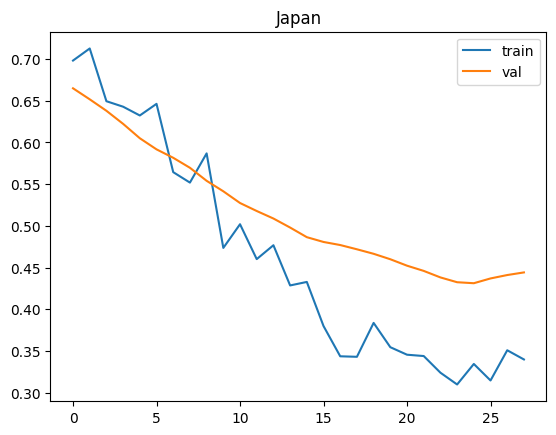

Korea (ROK)
Epoch 0: train loss 0.7902, val loss 1.3414, time 0.1027
Epoch 1: train loss 0.7850, val loss 1.3371, time 0.0885
Epoch 2: train loss 0.7781, val loss 1.3323, time 0.0879
Epoch 3: train loss 0.7670, val loss 1.3262, time 0.0897
Epoch 4: train loss 0.7528, val loss 1.3199, time 0.0884
Epoch 5: train loss 0.7389, val loss 1.3148, time 0.0892
Epoch 6: train loss 0.7178, val loss 1.3092, time 0.0895
Epoch 7: train loss 0.6886, val loss 1.3041, time 0.0885
Epoch 8: train loss 0.6589, val loss 1.3015, time 0.0880
Epoch 9: train loss 0.6151, val loss 1.2998, time 0.0890
Epoch 10: train loss 0.5588, val loss 1.2984, time 0.0884
Epoch 11: train loss 0.5118, val loss 1.2960, time 0.0963
Epoch 12: train loss 0.4709, val loss 1.2926, time 0.0874
Epoch 13: train loss 0.4379, val loss 1.2862, time 0.0846
Epoch 14: train loss 0.4032, val loss 1.2765, time 0.0848
Epoch 15: train loss 0.3862, val loss 1.2629, time 0.0854
Epoch 16: train loss 0.3686, val loss 1.2505, time 0.0844
Epoch 17: tr

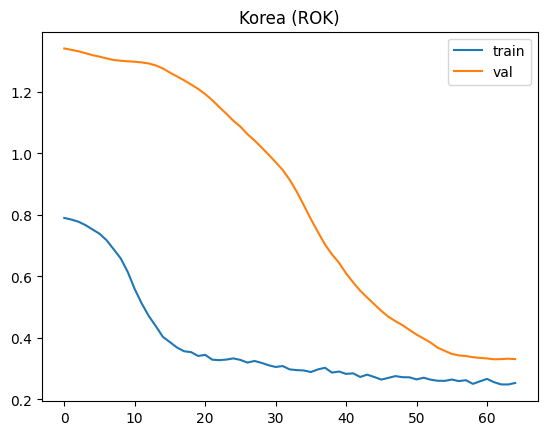

Macao, China
Epoch 0: train loss 0.7085, val loss 1.0903, time 0.0985
Epoch 1: train loss 0.6920, val loss 1.0904, time 0.0886
Epoch 2: train loss 0.6772, val loss 1.0897, time 0.0874
Epoch 3: train loss 0.6544, val loss 1.0898, time 0.0886
Epoch 4: train loss 0.6421, val loss 1.0893, time 0.0891
Epoch 5: train loss 0.6207, val loss 1.0893, time 0.0869
Epoch 6: train loss 0.5988, val loss 1.0895, time 0.0872
Epoch 7: train loss 0.5786, val loss 1.0903, time 0.0888
Epoch 8: train loss 0.5383, val loss 1.0903, time 0.0874
Epoch 9: train loss 0.5185, val loss 1.0927, time 0.0872
Epoch 10: train loss 0.4827, val loss 1.0940, time 0.0870
Epoch 11: train loss 0.4469, val loss 1.0941, time 0.0819
Epoch 12: train loss 0.4266, val loss 1.0931, time 0.0934
Epoch 13: train loss 0.4119, val loss 1.0929, time 0.0870
Early stopping as no improvement in val loss


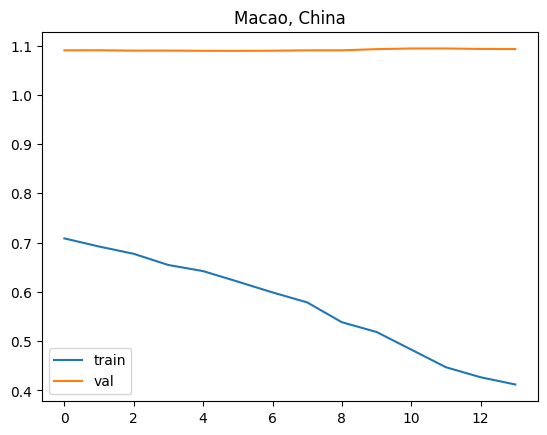

Maldives
Epoch 0: train loss 0.8063, val loss 0.5406, time 0.1141
Epoch 1: train loss 0.7672, val loss 0.5429, time 0.0996
Epoch 2: train loss 0.7808, val loss 0.5438, time 0.0922
Epoch 3: train loss 0.7529, val loss 0.5456, time 0.0928
Epoch 4: train loss 0.7653, val loss 0.5471, time 0.0934
Epoch 5: train loss 0.7107, val loss 0.5490, time 0.0997
Epoch 6: train loss 0.6874, val loss 0.5511, time 0.0934
Epoch 7: train loss 0.6448, val loss 0.5529, time 0.0942
Epoch 8: train loss 0.7027, val loss 0.5564, time 0.0926
Epoch 9: train loss 0.5579, val loss 0.5602, time 0.0923
Epoch 10: train loss 0.4823, val loss 0.5676, time 0.0919
Epoch 11: train loss 0.4427, val loss 0.5743, time 0.0980
Epoch 12: train loss 0.3960, val loss 0.5833, time 0.1045
Epoch 13: train loss 0.3621, val loss 0.5899, time 0.0936
Early stopping as no improvement in val loss


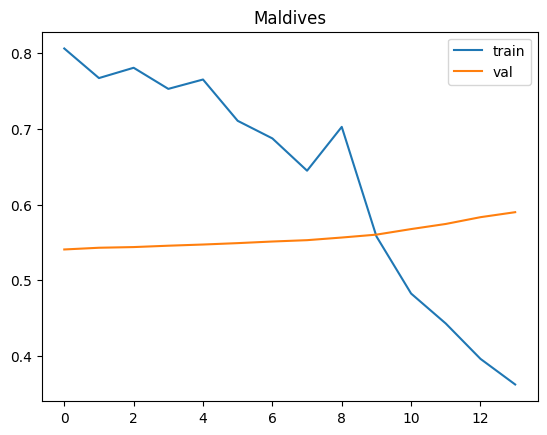

Cambodia
Epoch 0: train loss 0.7658, val loss 0.4814, time 0.0818
Epoch 1: train loss 0.7934, val loss 0.4800, time 0.0762
Epoch 2: train loss 0.8218, val loss 0.4746, time 0.0741
Epoch 3: train loss 0.7036, val loss 0.4727, time 0.0856
Epoch 4: train loss 0.7386, val loss 0.4709, time 0.0724
Epoch 5: train loss 0.7653, val loss 0.4681, time 0.0716
Epoch 6: train loss 0.6765, val loss 0.4656, time 0.0728
Epoch 7: train loss 0.6202, val loss 0.4636, time 0.0722
Epoch 8: train loss 0.6102, val loss 0.4615, time 0.0793
Epoch 9: train loss 0.5966, val loss 0.4600, time 0.0904
Epoch 10: train loss 0.5151, val loss 0.4576, time 0.0794
Epoch 11: train loss 0.4772, val loss 0.4544, time 0.0720
Epoch 12: train loss 0.4343, val loss 0.4519, time 0.0723
Epoch 13: train loss 0.4463, val loss 0.4507, time 0.0724
Epoch 14: train loss 0.4121, val loss 0.4476, time 0.0721
Epoch 15: train loss 0.3812, val loss 0.4471, time 0.0731
Epoch 16: train loss 0.3795, val loss 0.4493, time 0.0723
Epoch 17: train

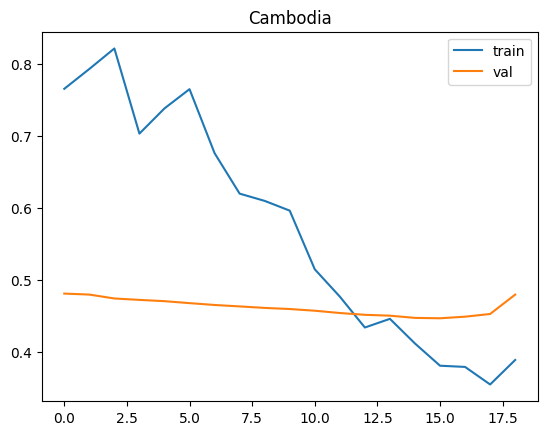

Indonesia
Epoch 0: train loss 0.9669, val loss 0.5747, time 0.0354
Epoch 1: train loss 0.9861, val loss 0.5791, time 0.0317
Epoch 2: train loss 0.9079, val loss 0.5877, time 0.0308
Epoch 3: train loss 0.9183, val loss 0.5952, time 0.0304
Epoch 4: train loss 0.9950, val loss 0.5999, time 0.0304
Epoch 5: train loss 0.8961, val loss 0.6101, time 0.0312
Epoch 6: train loss 0.9489, val loss 0.6138, time 0.0305
Epoch 7: train loss 0.8740, val loss 0.6220, time 0.0333
Epoch 8: train loss 0.9208, val loss 0.6271, time 0.0450
Epoch 9: train loss 0.8662, val loss 0.6333, time 0.0300
Epoch 10: train loss 0.8066, val loss 0.6393, time 0.0298
Epoch 11: train loss 0.8526, val loss 0.6464, time 0.0297
Epoch 12: train loss 0.7670, val loss 0.6520, time 0.0323
Epoch 13: train loss 0.7510, val loss 0.6560, time 0.0330
Early stopping as no improvement in val loss


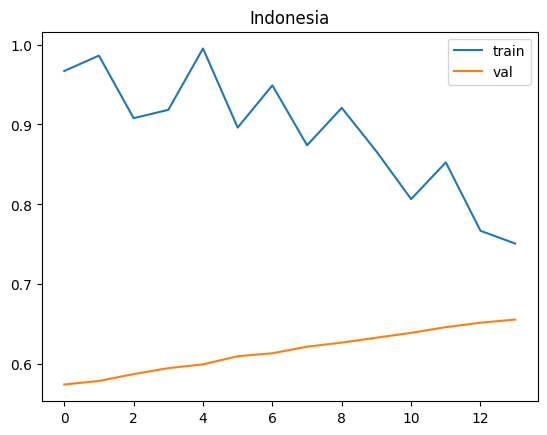

Singapore
Epoch 0: train loss 0.6141, val loss 0.8344, time 0.0863
Epoch 1: train loss 0.6166, val loss 0.8301, time 0.0769
Epoch 2: train loss 0.6119, val loss 0.8236, time 0.0874
Epoch 3: train loss 0.5949, val loss 0.8151, time 0.0756
Epoch 4: train loss 0.5581, val loss 0.8073, time 0.0771
Epoch 5: train loss 0.5361, val loss 0.7971, time 0.0758
Epoch 6: train loss 0.5232, val loss 0.7844, time 0.0766
Epoch 7: train loss 0.5024, val loss 0.7718, time 0.0763
Epoch 8: train loss 0.5156, val loss 0.7575, time 0.0750
Epoch 9: train loss 0.5062, val loss 0.7420, time 0.0755
Epoch 10: train loss 0.4387, val loss 0.7290, time 0.0765
Epoch 11: train loss 0.5039, val loss 0.7158, time 0.0761
Epoch 12: train loss 0.4651, val loss 0.6990, time 0.0761
Epoch 13: train loss 0.4563, val loss 0.6822, time 0.0759
Epoch 14: train loss 0.3965, val loss 0.6656, time 0.0758
Epoch 15: train loss 0.4193, val loss 0.6475, time 0.0764
Epoch 16: train loss 0.3892, val loss 0.6305, time 0.0757
Epoch 17: trai

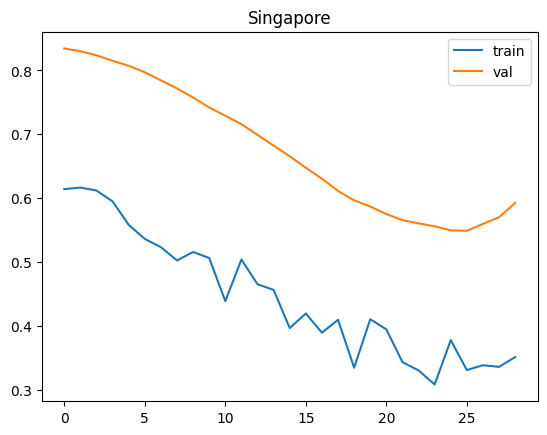

New Zealand
Epoch 0: train loss 0.6978, val loss 0.7817, time 0.0869
Epoch 1: train loss 0.6692, val loss 0.7734, time 0.0760
Epoch 2: train loss 0.6630, val loss 0.7648, time 0.0746
Epoch 3: train loss 0.5827, val loss 0.7591, time 0.0756
Epoch 4: train loss 0.6069, val loss 0.7560, time 0.0752
Epoch 5: train loss 0.6300, val loss 0.7499, time 0.0758
Epoch 6: train loss 0.5779, val loss 0.7399, time 0.0758
Epoch 7: train loss 0.5780, val loss 0.7303, time 0.0762
Epoch 8: train loss 0.5305, val loss 0.7194, time 0.0744
Epoch 9: train loss 0.5758, val loss 0.7017, time 0.0770
Epoch 10: train loss 0.5126, val loss 0.6857, time 0.0759
Epoch 11: train loss 0.4727, val loss 0.6647, time 0.0759
Epoch 12: train loss 0.4315, val loss 0.6429, time 0.0775
Epoch 13: train loss 0.4096, val loss 0.6205, time 0.0764
Epoch 14: train loss 0.4641, val loss 0.5907, time 0.0887
Epoch 15: train loss 0.4144, val loss 0.5701, time 0.0765
Epoch 16: train loss 0.4043, val loss 0.5516, time 0.0766
Epoch 17: tr

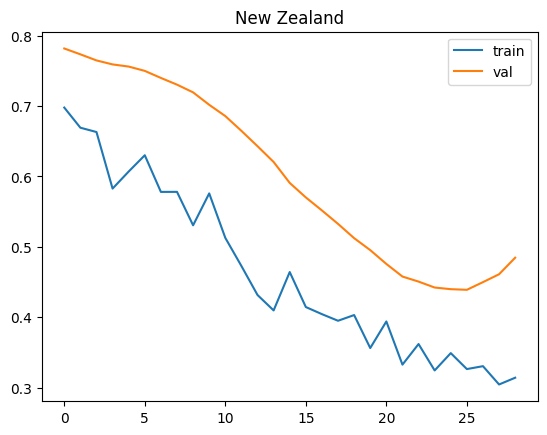

USA
Epoch 0: train loss 0.8438, val loss 0.4394, time 0.0940
Epoch 1: train loss 0.8381, val loss 0.4388, time 0.0832
Epoch 2: train loss 0.8329, val loss 0.4382, time 0.0816
Epoch 3: train loss 0.8249, val loss 0.4379, time 0.0830
Epoch 4: train loss 0.8134, val loss 0.4375, time 0.0820
Epoch 5: train loss 0.7747, val loss 0.4367, time 0.0832
Epoch 6: train loss 0.7625, val loss 0.4382, time 0.0830
Epoch 7: train loss 0.7428, val loss 0.4391, time 0.0831
Epoch 8: train loss 0.6947, val loss 0.4395, time 0.0806
Epoch 9: train loss 0.6500, val loss 0.4386, time 0.0815
Epoch 10: train loss 0.6163, val loss 0.4377, time 0.0818
Epoch 11: train loss 0.5862, val loss 0.4359, time 0.0830
Epoch 12: train loss 0.5191, val loss 0.4318, time 0.0830
Epoch 13: train loss 0.4993, val loss 0.4259, time 0.0828
Epoch 14: train loss 0.4656, val loss 0.4171, time 0.0810
Epoch 15: train loss 0.4340, val loss 0.4129, time 0.0835
Epoch 16: train loss 0.4312, val loss 0.4081, time 0.0828
Epoch 17: train loss

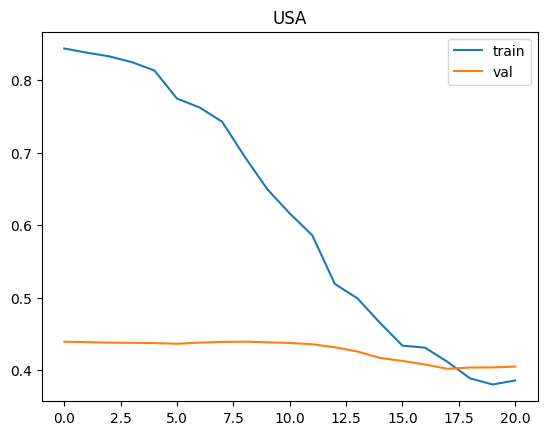

Thailand
Epoch 0: train loss 0.6485, val loss 0.4798, time 0.1188
Epoch 1: train loss 0.6275, val loss 0.4812, time 0.1154
Epoch 2: train loss 0.6354, val loss 0.4823, time 0.1060
Epoch 3: train loss 0.6124, val loss 0.4829, time 0.1041
Epoch 4: train loss 0.6129, val loss 0.4825, time 0.1045
Epoch 5: train loss 0.5837, val loss 0.4814, time 0.1034
Epoch 6: train loss 0.5603, val loss 0.4799, time 0.1048
Epoch 7: train loss 0.5367, val loss 0.4778, time 0.1032
Epoch 8: train loss 0.5136, val loss 0.4771, time 0.1049
Epoch 9: train loss 0.4861, val loss 0.4795, time 0.1036
Epoch 10: train loss 0.4532, val loss 0.4819, time 0.1050
Epoch 11: train loss 0.4130, val loss 0.4860, time 0.1042
Epoch 12: train loss 0.3957, val loss 0.4926, time 0.1051
Epoch 13: train loss 0.3719, val loss 0.4976, time 0.1044
Early stopping as no improvement in val loss


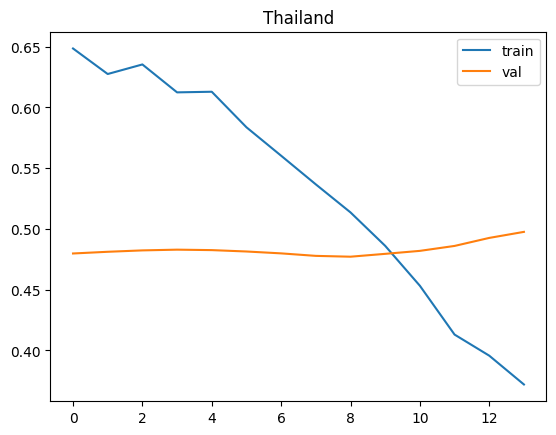

Turkey
Epoch 0: train loss 0.7576, val loss 0.4945, time 0.0973
Epoch 1: train loss 0.7540, val loss 0.4961, time 0.0859
Epoch 2: train loss 0.7382, val loss 0.4995, time 0.0843
Epoch 3: train loss 0.7221, val loss 0.5025, time 0.0835
Epoch 4: train loss 0.7093, val loss 0.5024, time 0.0861
Epoch 5: train loss 0.7034, val loss 0.5137, time 0.0845
Epoch 6: train loss 0.6748, val loss 0.5319, time 0.0848
Epoch 7: train loss 0.6479, val loss 0.5493, time 0.0858
Epoch 8: train loss 0.6074, val loss 0.5633, time 0.0838
Epoch 9: train loss 0.5750, val loss 0.5818, time 0.0825
Epoch 10: train loss 0.5457, val loss 0.5910, time 0.0848
Epoch 11: train loss 0.5158, val loss 0.6018, time 0.0838
Epoch 12: train loss 0.4910, val loss 0.6143, time 0.0853
Epoch 13: train loss 0.4564, val loss 0.6294, time 0.0854
Early stopping as no improvement in val loss


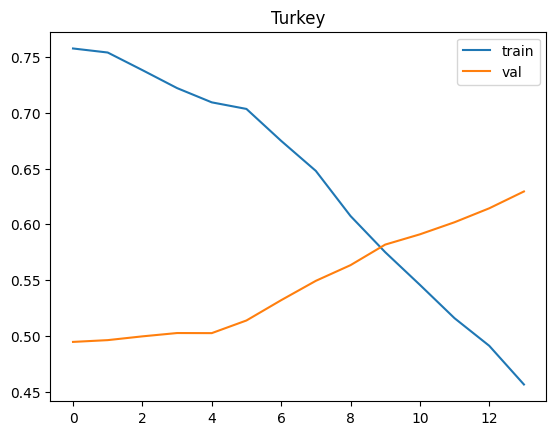

Australia
Epoch 0: train loss 0.8084, val loss 0.3648, time 0.1481
Epoch 1: train loss 0.7990, val loss 0.3661, time 0.1300
Epoch 2: train loss 0.7820, val loss 0.3681, time 0.1305
Epoch 3: train loss 0.7686, val loss 0.3658, time 0.1294
Epoch 4: train loss 0.7457, val loss 0.3582, time 0.1312
Epoch 5: train loss 0.6900, val loss 0.3571, time 0.1280
Epoch 6: train loss 0.6176, val loss 0.3595, time 0.1306
Epoch 7: train loss 0.5317, val loss 0.3613, time 0.1291
Epoch 8: train loss 0.4759, val loss 0.3607, time 0.1336
Epoch 9: train loss 0.4392, val loss 0.3619, time 0.1323
Epoch 10: train loss 0.4075, val loss 0.3668, time 0.1313
Epoch 11: train loss 0.3885, val loss 0.3767, time 0.1317
Epoch 12: train loss 0.3590, val loss 0.3895, time 0.1335
Epoch 13: train loss 0.3454, val loss 0.3982, time 0.1330
Early stopping as no improvement in val loss


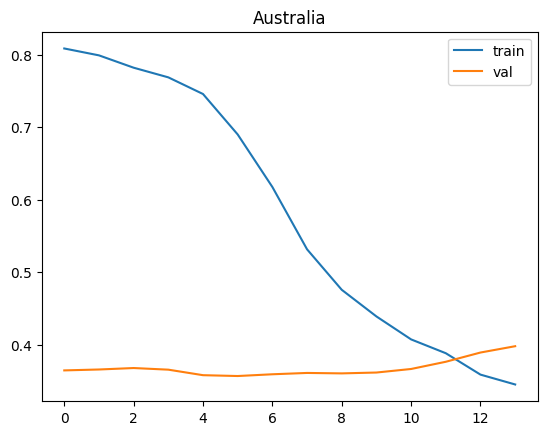

Hawaii
Epoch 0: train loss 0.9995, val loss 0.9543, time 0.1114
Epoch 1: train loss 0.7704, val loss 0.9520, time 0.0954
Epoch 2: train loss 0.6891, val loss 0.9491, time 0.0957
Epoch 3: train loss 0.7968, val loss 0.9468, time 0.0946
Epoch 4: train loss 0.7644, val loss 0.9414, time 0.0950
Epoch 5: train loss 0.7058, val loss 0.9336, time 0.0962
Epoch 6: train loss 0.6208, val loss 0.9228, time 0.0961
Epoch 7: train loss 0.6003, val loss 0.9128, time 0.0947
Epoch 8: train loss 0.5925, val loss 0.9026, time 0.0956
Epoch 9: train loss 0.5594, val loss 0.8914, time 0.0960
Epoch 10: train loss 0.6018, val loss 0.8771, time 0.1039
Epoch 11: train loss 0.5035, val loss 0.8593, time 0.0939
Epoch 12: train loss 0.4933, val loss 0.8405, time 0.0946
Epoch 13: train loss 0.4571, val loss 0.8173, time 0.1074
Epoch 14: train loss 0.4633, val loss 0.7889, time 0.0921
Epoch 15: train loss 0.4441, val loss 0.7683, time 0.0940
Epoch 16: train loss 0.4348, val loss 0.7434, time 0.0938
Epoch 17: train l

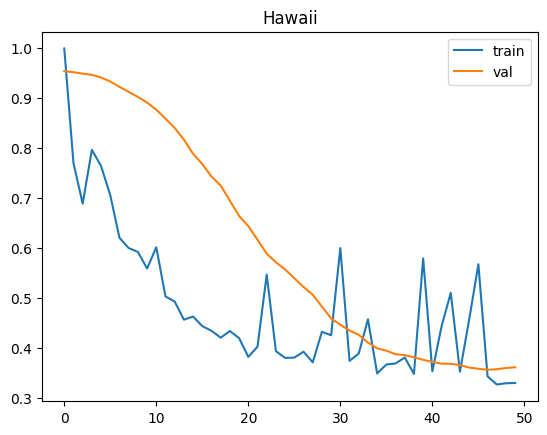

Austria
Epoch 0: train loss 0.6247, val loss 0.5794, time 0.0836
Epoch 1: train loss 0.7514, val loss 0.5744, time 0.0718
Epoch 2: train loss 0.8856, val loss 0.5656, time 0.0713
Epoch 3: train loss 0.6781, val loss 0.5614, time 0.0712
Epoch 4: train loss 0.8497, val loss 0.5457, time 0.0721
Epoch 5: train loss 0.5605, val loss 0.5404, time 0.0706
Epoch 6: train loss 0.6602, val loss 0.5370, time 0.0726
Epoch 7: train loss 0.5824, val loss 0.5334, time 0.0718
Epoch 8: train loss 0.8780, val loss 0.5207, time 0.0710
Epoch 9: train loss 0.5620, val loss 0.5136, time 0.0705
Epoch 10: train loss 0.5295, val loss 0.5065, time 0.0719
Epoch 11: train loss 0.6090, val loss 0.4996, time 0.0888
Epoch 12: train loss 0.5655, val loss 0.4907, time 0.0713
Epoch 13: train loss 0.5626, val loss 0.4790, time 0.0722
Epoch 14: train loss 0.5791, val loss 0.4676, time 0.0709
Epoch 15: train loss 0.5799, val loss 0.4436, time 0.0702
Epoch 16: train loss 0.4442, val loss 0.4324, time 0.0714
Epoch 17: train 

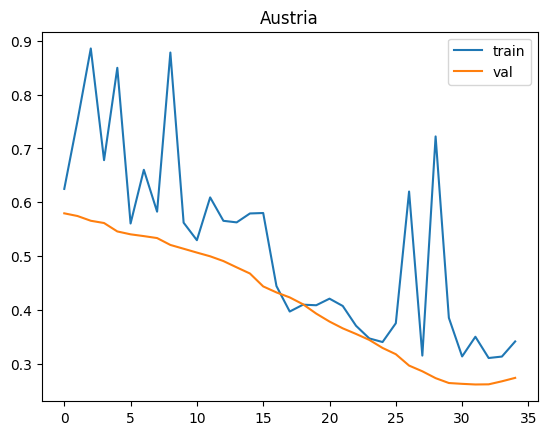

Czech
Epoch 0: train loss 0.9585, val loss 0.4282, time 0.0376
Epoch 1: train loss 0.9029, val loss 0.4278, time 0.0339
Epoch 2: train loss 0.9221, val loss 0.4260, time 0.0331
Epoch 3: train loss 0.8658, val loss 0.4238, time 0.0330
Epoch 4: train loss 0.8718, val loss 0.4212, time 0.0334
Epoch 5: train loss 0.9101, val loss 0.4168, time 0.0329
Epoch 6: train loss 0.9427, val loss 0.4112, time 0.0328
Epoch 7: train loss 0.8747, val loss 0.4067, time 0.0325
Epoch 8: train loss 0.8157, val loss 0.4004, time 0.0340
Epoch 9: train loss 0.8287, val loss 0.3931, time 0.0335
Epoch 10: train loss 0.8530, val loss 0.3842, time 0.0331
Epoch 11: train loss 0.8421, val loss 0.3735, time 0.0344
Epoch 12: train loss 0.8213, val loss 0.3642, time 0.0329
Epoch 13: train loss 0.7855, val loss 0.3538, time 0.0329
Epoch 14: train loss 0.7329, val loss 0.3458, time 0.0336
Epoch 15: train loss 0.7429, val loss 0.3367, time 0.0333
Epoch 16: train loss 0.6493, val loss 0.3304, time 0.0338
Epoch 17: train lo

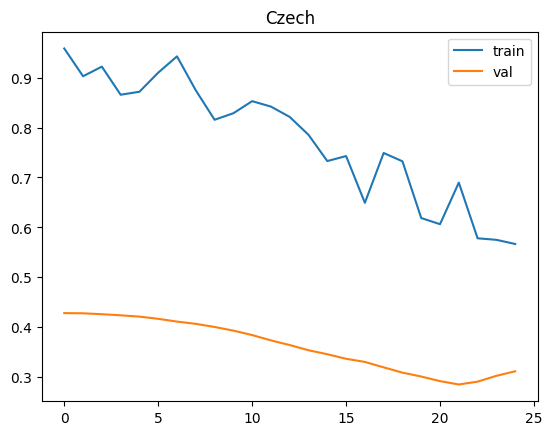

In [54]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, seq_test_x, seq_test_y = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=22, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = nn.L1Loss()

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
    # train_dataset.initialize_states()
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
    # test_dataset.set_initial_states(train_dataset.get_initial_states())
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

    _, ds_x, ds_y = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

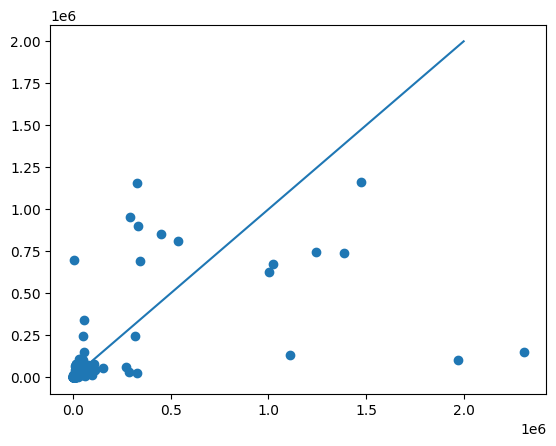

In [55]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((0, 2000000), (0, 2000000))

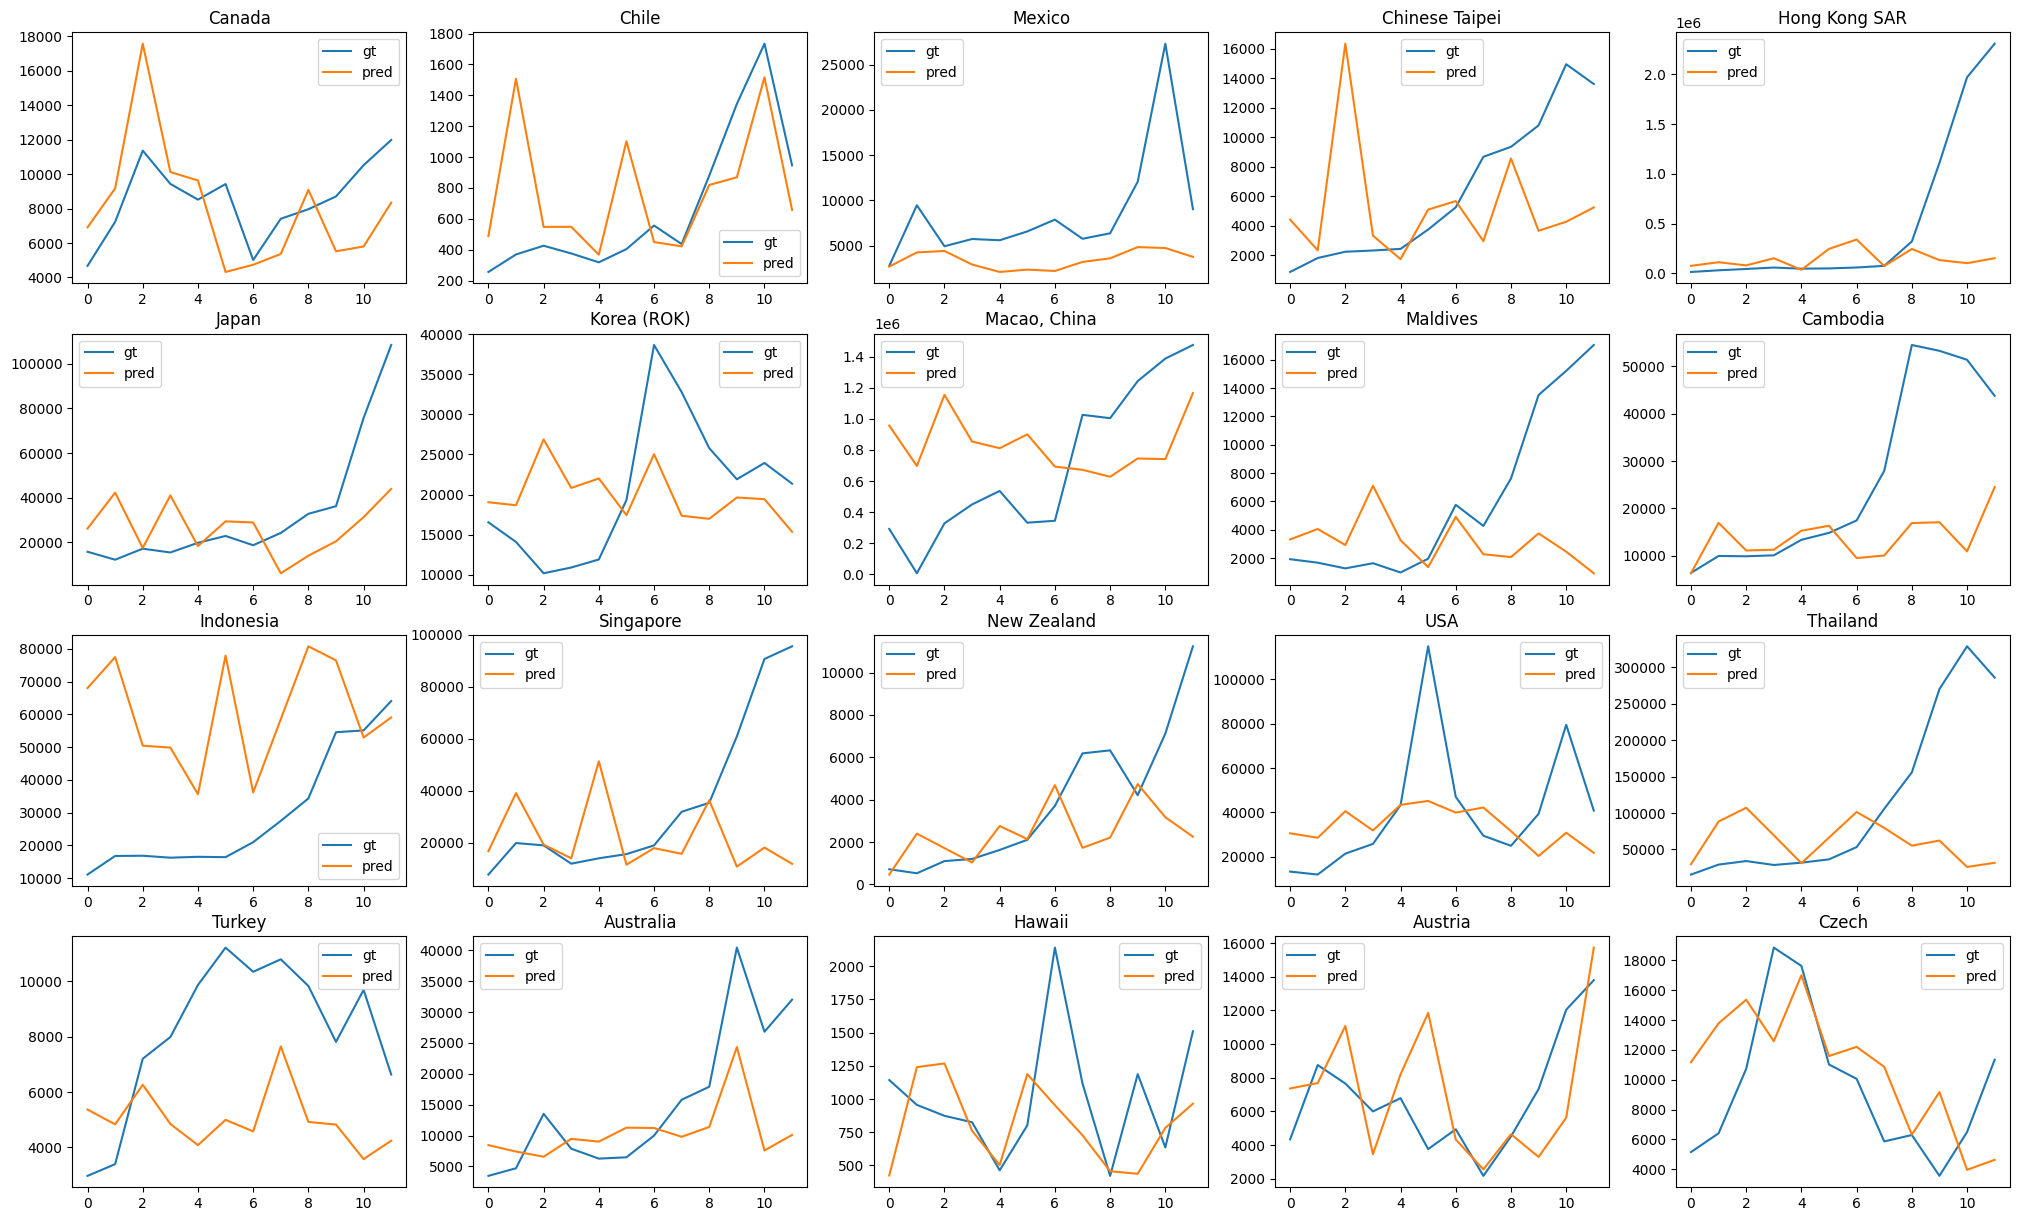

In [ ]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [ ]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}\nRNN Sep MAPE: {rnn_sep_mape:.5f}')

RNN Sep RMSE: 231304.88057
RNN Sep R2: 0.29068
RNN Sep MAE: 61914.55457
RNN Sep MAPE: 1.14515


# Final Run
Using RNN forecast 18 months at once and also forecast one month at a time

In [104]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 'CovidCases', 'CovidDeaths', 'TravelPolicy', 'GlobalCovidTrend',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window_full(df, input_len=100, output_len=12,):
    df = df.copy().dropna()
    x, y = [], []
    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
    y = np.asarray(y)
    return x, y

Epoch 0: train loss 0.5985, time 1.6849
Epoch 1: train loss 0.3977, time 1.4656
Epoch 2: train loss 0.3718, time 1.4734
Epoch 3: train loss 0.3562, time 1.5235
Epoch 4: train loss 0.3476, time 1.4647
Epoch 5: train loss 0.3395, time 1.4606
Epoch 6: train loss 0.3334, time 1.4718
Epoch 7: train loss 0.3334, time 1.4367
Epoch 8: train loss 0.3282, time 1.4503
Epoch 9: train loss 0.3222, time 1.4455
warning not converged


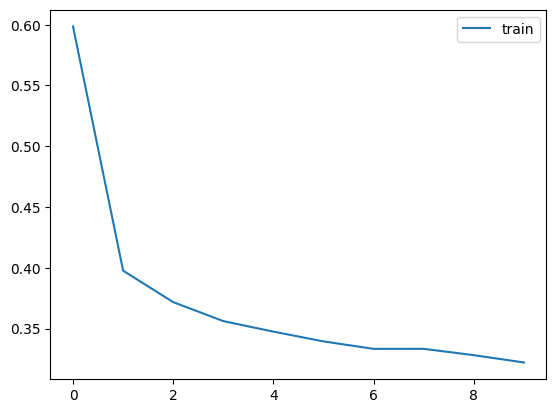

In [89]:
# predicting 18 steps at once
# advantage is that it is numerically stable does not require autoregressive predicting
# disadvantage is model only learn up to 18 timesteps before the forecasting starting point

best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})
output_size = 18
seq_len = best_param[0]['seq_len']
seq_train_x_ori, seq_train_y_ori = [], []
for country in country_list:
    seq_train_x, seq_train_y = sliding_window_full(all_data[country], input_len=best_param[0]['seq_len'], 
                                                   output_len=output_size)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)

seq_train_y_ori = np.concatenate(seq_train_y_ori)

model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.L1Loss()

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori,)# (model.num_layers, model.hidden_size))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)

model, train_losses, _ = train_rnn(model, criterion, optimizer, train_dataloader, cuda=True, epochs=10, save_best=False)
plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
plt.legend();
torch.save(model.state_dict(), './final_multistep_rnn.pth')


In [ ]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, dt = [], []
for country, df in all_data.items():
    df = df.copy()
    test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
    required_steps = math.ceil(len(test_y) / output_size)
    preds = []
    for i in range(required_steps):
        test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
        test_x = df.loc[:test_y_.index[0]].iloc[-seq_len-1:-1]
        # display(test_x)
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x):]
            test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
        # display(test_x)
        # display(test_y_)
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()[0]
        preds.append(pred)
    preds = np.concatenate(preds)
    dt.append(test_y.index)
    rnn_preds.append(preds[:len(test_y)])

In [91]:
rnn_pred = []

for i, country in enumerate(all_data.keys()):
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[dt[i] - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    

Epoch 0: train loss 0.3238, time 1.6694
Epoch 1: train loss 0.1323, time 1.4370
Epoch 2: train loss 0.0893, time 1.4281
Epoch 3: train loss 0.0829, time 1.4279
Epoch 4: train loss 0.0794, time 1.4295
Epoch 5: train loss 0.0785, time 1.4195
Epoch 6: train loss 0.0759, time 1.4479
Epoch 7: train loss 0.0721, time 1.4207
Epoch 8: train loss 0.0723, time 1.4290
Epoch 9: train loss 0.0726, time 1.4279
warning not converged


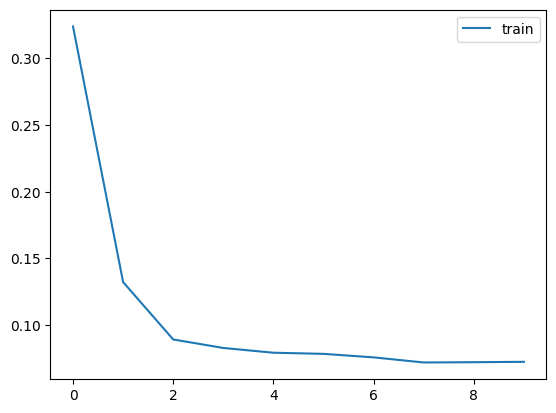

In [97]:
# predicting 1 steps at once
# advantage is model can learn more data and utilize future values to predict
# disadvantage is not as stable because prediction is done autoregressively and error propagates through each time step

best_param = ({'seq_len': 36, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.0005})
output_size = 1
seq_len = best_param[0]['seq_len']
seq_train_x_ori, seq_train_y_ori = [], []
for country in country_list:
    seq_train_x, seq_train_y = sliding_window_full(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)

seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()

onestep_model = ForecastModel(**best_param[1], input_size=23, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], onestep_model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori,)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)

onestep_model, train_losses, _ = train_rnn(onestep_model, criterion, optimizer, train_dataloader, cuda=True, epochs=10, save_best=False)
plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
plt.legend();
torch.save(onestep_model.state_dict(), './final_onestep_rnn.pth')


In [ ]:
# rnn_preds, _ = eval_rnn(onestep_model, criterion, test_dataloader)

# auto regressive predictions
onestep_model.eval()
rnn_preds, dt = [], []
for country, df in all_data.items():
    df = df.copy()
    test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
    required_steps = math.ceil(len(test_y) / output_size)
    preds = []
    for i in range(required_steps):
        test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
        test_x = df.loc[:test_y_.index[0]].iloc[-seq_len-1:-1]
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x):]
            test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = onestep_model.get_embeddings([country])
            x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = onestep_model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
    preds = np.concatenate(preds)
    dt.append(test_y.index)
    rnn_preds.append(preds[:len(test_y)])

In [99]:
rnn_onestep_pred = []

for i, country in enumerate(all_data.keys()):
    rnn_onestep_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[dt[i] - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    

# Ensemble

In [302]:
# ensembling both for whichever make more sense
def make_prediction(multistep_model, onestep_model, seq_len=(24, 36), dropout=False, dropout_p=None):
    weights = {'Chile': (0.1, 0.5), 'Mexico': (0.7, 0.3), 'Chinese Taipei': (0.3, 0.7), 'Hong Kong SAR': (0.4, 0.6), 'Macao, China': (0.8, 0.2),
               'Indonesia': (0.3, 0.7), 'USA': (0.7, 0.3), 'Thailand': (0.3, 0.7), 'Turkey': (0.3, 0.7)}
    multistep_model.eval()
    onestep_model.eval()
    if dropout:
        if dropout_p is not None:
            multistep_model.dropout.p = dropout_p
            onestep_model.dropout.p = dropout_p
            multistep_model.rnn.dropout = dropout_p
            onestep_model.rnn.dropout = dropout_p
        multistep_model.dropout.train()
        onestep_model.dropout.train()
        multistep_model.rnn.train() # to enable dropout in rnn
        onestep_model.rnn.train()
    rnn_preds, dt = [], []
    for country, df in all_data.items():
        output_size = 18
        df = df.copy()
        test_y = df.loc[df['VisitorArrivals'].last_valid_index():].iloc[1:]
        required_steps = math.ceil(len(test_y) / output_size)
        assert required_steps == 1
        preds = []
        for i in range(required_steps):
            test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
            test_x = df.loc[:test_y_.index[0]].iloc[-seq_len[0]-1:-1]
            if i > 0:
                last_pred = np.concatenate(preds)[-len(test_x):]
                test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred

            with torch.no_grad():
                init_state = multistep_model.get_embeddings([country])
                x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = multistep_model(x_input, init_state).detach().cpu().numpy()[0]
            preds.append(pred)
        preds = np.concatenate(preds)
        # one step at a time
        output_size = 1
        required_steps = math.ceil(len(test_y) / output_size)
        onestep_preds = []
        for i in range(required_steps):
            test_y_ = test_y.iloc[i*output_size: i*output_size+output_size]
            test_x = df.loc[:test_y_.index[0]].iloc[-seq_len[1]-1:-1]
            if i > 0:
                last_pred = np.concatenate(onestep_preds)[-len(test_x):]
                test_x.iloc[-len(last_pred):, test_x.columns.get_loc('VisitorArrivals')] = last_pred
            with torch.no_grad():
                init_state = onestep_model.get_embeddings([country])
                x_input = torch.from_numpy(test_x[country_feat + universal_feat + [target]].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = onestep_model(x_input, init_state).detach().cpu().numpy()
            onestep_preds.append(pred)
        onestep_preds = np.concatenate(onestep_preds)
        
        preds = inverse_target(preds[:len(test_y)], all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                               y_scaler if single_y_scaler else y_scaler[country])
        onestep_preds = inverse_target(onestep_preds[:len(test_y)], all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=6)].values if deduct_seasonality else 0.,
                                       y_scaler if single_y_scaler else y_scaler[country])
        
        w = weights.get(country, (0.5, 0.5))
        rnn_pred = w[0] * preds + (w[1]) * onestep_preds
        rnn_preds.append(rnn_pred)
        dt.append(test_y.index)
    return rnn_preds, dt

In [228]:
multistep_model = ForecastModel(model_type='gru', num_layers=3, hidden_size=50, input_size=23, output_size=18, conditional_labels=country_list)
multistep_model.load_state_dict(torch.load('./final_multistep_rnn.pth'))
multistep_model.cuda()
onestep_model = ForecastModel(model_type='gru', num_layers=1, hidden_size=100, input_size=23, output_size=1, conditional_labels=country_list)
onestep_model.load_state_dict(torch.load('./final_onestep_rnn.pth'))
onestep_model.cuda()

ForecastModel(
  (rnn): GRU(23, 100, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (cond_emb): Embedding(20, 100)
)

In [229]:
ensemble_rnn, dt = make_prediction(multistep_model, onestep_model)

In [230]:
# plot
def final_process(rnn_pred, dt, plot=False):
    rnn_pred = rnn_pred.copy()
    if plot:
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
    pred_dfs = []

    for i, (country, country_df) in enumerate(all_data.items()):
        if plot:
            row, col = i // 5, i % 5
            ax = axes[row, col]
        # print(row, col)
        country_df = country_df.copy()

        seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(country_df))
        assert len(seasonal_component) == len(country_df)
        seasonal_component.index = country_df.index
        seasonal_component[(seasonal_component.index >= '2020-01-01') & (seasonal_component.index <= '2023-01-01')] = 0 # no seasonality during covid
        country_df['VisitorArrivals'] = inverse_target(country_df['VisitorArrivals'], seasonal_component if deduct_seasonality else 0., y_scaler if single_y_scaler else y_scaler[country])
        pred_df = pd.DataFrame({'VisitorArrivals': rnn_pred[i]}, index=dt[i])

        last = country_df['VisitorArrivals'].dropna().iloc[-1]
        if pred_df['VisitorArrivals'].iloc[0] > last * 1.3:
            diff = (last * 1.2 - pred_df['VisitorArrivals'].iloc[0]) * 0.8
        elif pred_df['VisitorArrivals'].iloc[0] < last * 0.8:
            diff = last * 0.8 - pred_df['VisitorArrivals'].iloc[0]
        else:
            diff = 0
        pred_df['VisitorArrivals'] += diff
        
        if plot:
            start_date = min(dt[i])
            country_df = country_df.iloc[-120:]
            country_df['VisitorArrivals'].plot(ax=ax)
            pred_df['VisitorArrivals'].plot(ax=ax)
            ax.set_title(country)
            # ax.axvline(start_date, color='black')
        pred_dfs.append(pred_df[pred_df.index > '2023-07-01'].rename(columns={'VisitorArrivals': country}).astype(int))
        rnn_pred[i] = pred_df['VisitorArrivals'].values

    pred_dfs = pd.concat(pred_dfs, axis=1)
    if plot:
        plt.tight_layout()
        plt.show()
    return pred_dfs, rnn_pred

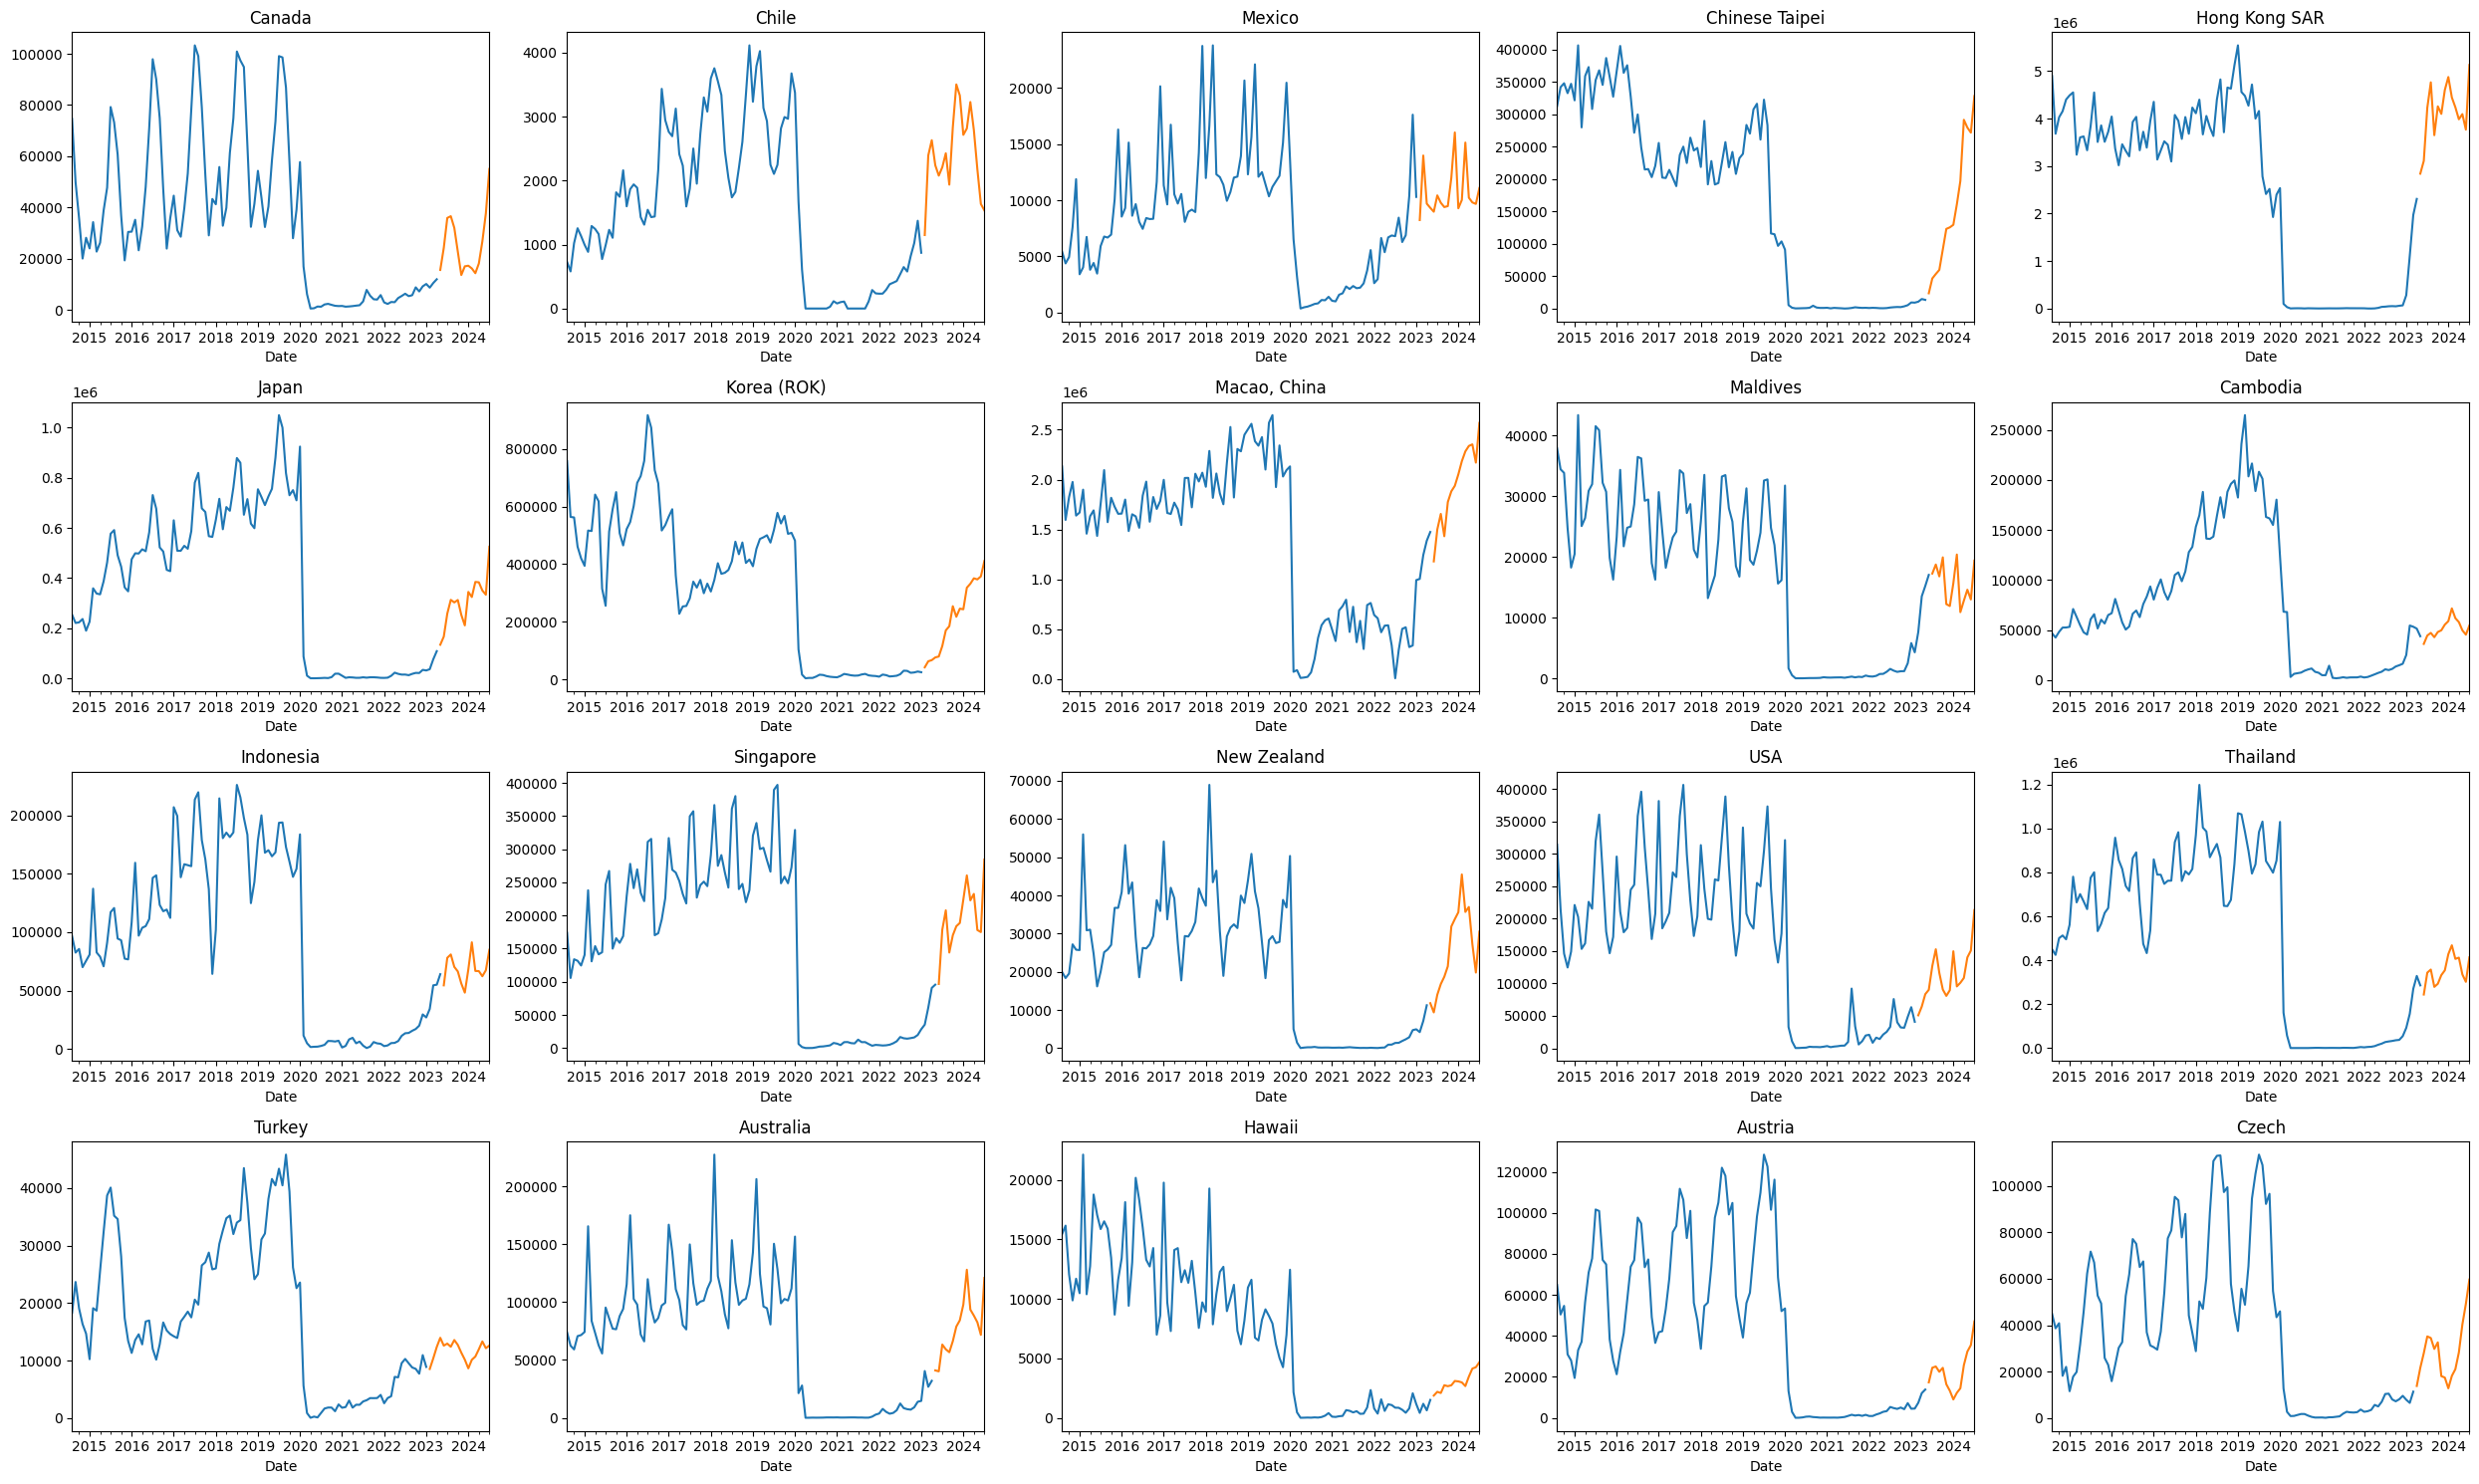

In [231]:
save_path = './data/point_prediction.csv'
pred_dfs, final_pred = final_process(ensemble_rnn, dt, plot=True)
pred_dfs.to_csv(save_path)

In [232]:
pred_dfs

Canada  Chile  Mexico  Chinese Taipei  Hong Kong SAR   Japan  \
Date                                                                       
2023-08-01   36607   2427    9782           53516        4764073  312979   
2023-09-01   32049   1936    9397           59852        3651346  302750   
2023-10-01   22769   2832    9483           91354        4258672  312442   
2023-11-01   13630   3504   12006          123127        4099816  252860   
2023-12-01   17035   3330   16044          125489        4604520  211059   
2024-01-01   17272   2715    9288          129445        4876232  344700   
2024-02-01   16200   2815   10030          161023        4446013  324321   
2024-03-01   14346   3228   15142          196992        4239638  384626   
2024-04-01   18134   2791   10233          291410        3986395  383046   
2024-05-01   26757   2177    9812          279434        4094923  350416   
2024-06-01   37730   1634    9679          271606        3768493  333589   
2024-07-01   55043   1535   11090          328014        5129324  525177   

            Korea (ROK)  Macao, China  Maldives  Cambodia  Indonesia  \
Date                                                                   
2023-08-01       170185       1655854     18735     47090      80947   
2023-09-01       184716       1431982     16783     42765      70320   
2023-10-01       254170       1774469     19917     47974      66411   
2023-11-01       217471       1882104     12215     49687      56047   
2023-12-01       245640       1937660     11900     55354      48283   
2024-01-01       243413       2052160     15655     58836      68153   
2024-02-01       318361       2184142     20380     71566      91328   
2024-03-01       332067       2282543     10889     61809      66839   
2024-04-01       350967       2337314     12786     57904      66691   
2024-05-01       347165       2353157     14587     49672      62307   
2024-06-01       357492       2170033     12979     45328      67425   
2024-07-01       410886       2567900     19378     54403      84889   

            Singapore  New Zealand     USA  Thailand  Turkey  Australia  \
Date                                                                      
2023-08-01     207726        16786  152741    357468   12406      59202   
2023-09-01     144091        18705  116231    278648   13577      56713   
2023-10-01     170055        21440   90601    292633   12729      66203   
2023-11-01     183772        31855   80813    332235   11375      78849   
2023-12-01     188674        33790   89540    354009   10163      84277   
2024-01-01     224097        35586  149588    427925    8649      97870   
2024-02-01     260448        45473   95444    468086   10135     127944   
2024-03-01     222802        35668  100991    406133   10698      93509   
2024-04-01     232557        36962  108435    411900   11970      88351   
2024-05-01     178044        27258  140139    335408   13330      82560   
2024-06-01     174965        19802  150697    301609   12154      71685   
2024-07-01     284421        30502  213086    413110   12616     120876   

            Hawaii  Austria  Czech  
Date                                
2023-08-01    2091    25049  34479  
2023-09-01    2745    22457  29761  
2023-10-01    2664    24380  32594  
2023-11-01    2740    16380  18034  
2023-12-01    3101    13200  17412  
2024-01-01    3067     8961  12782  
2024-02-01    2981    12186  18130  
2024-03-01    2672    14412  21024  
2024-04-01    3469    25674  28227  
2024-05-01    4142    32322  40275  
2024-06-01    4257    35481  49210  
2024-07-01    4673    47012  59673

# Interval Forecast
With Monte Carlo dropout method

In [303]:
def monte_carlo_dropout(trials, initial_pred=None, dropout_p=None):
    trials -= 1
    assert trials > 0
    if initial_pred is None:
        initial_pred, dt = make_prediction(multistep_model, onestep_model, dropout=False)
        _, initial_pred = final_process(initial_pred, dt, plot=False)
    for _ in tqdm(range(trials)):
        dropout_pred, dt = make_prediction(multistep_model, onestep_model, dropout=True, dropout_p=dropout_p)
        _, dropout_pred = final_process(dropout_pred, dt, plot=False)
        for i in range(len(dropout_pred)):
            mc_samples[i].append(dropout_pred[i])

    for i in range(len(mc_samples)):
        mc_samples[i] = np.asarray(mc_samples[i])
    return mc_samples

In [305]:
# def get_confidence_interval(samples, alpha=.2):
#     all_lower, all_upper = [], []
#     for sample in samples:
#         lower, upper = sms.DescrStatsW(sample).tconfint_mean(alpha=alpha)
#         all_lower.append(lower)
#         all_upper.append(upper)
#     return all_lower, all_upper

def get_confidence_interval(samples, confidence=0.8):
    ci = []
    for sample in samples:
        n = len(sample)
        se = scipy.stats.sem(sample, axis=0)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        ci.append(h)
    return ci

In [325]:
# plot
def final_interval_process(rnn_pred, dt, lower, upper, plot=False):
    rnn_pred = rnn_pred.copy()
    if plot:
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))
    pred_dfs = []

    for i, (country, country_df) in enumerate(all_data.items()):
        if plot:
            row, col = i // 5, i % 5
            ax = axes[row, col]
        # print(row, col)
     
        if plot:
            pred_df = pd.DataFrame({'VisitorArrivals': rnn_pred[i]}, index=dt[i])
            pred_df = pred_df[pred_df.index > '2023-07-01']
            start_date = min(dt[i])
            pred_df['VisitorArrivals'].plot(ax=ax)
            ax.fill_between(dt[i], lower[i], upper[i], alpha=.25)

            ax.set_title(country)
            # ax.axvline(start_date, color='black')
            
        pred_df = pd.DataFrame({country + 'Lower': lower[i], country + 'Upper': upper[i]}, index=dt[i])
        pred_dfs.append(pred_df[pred_df.index > '2023-07-01'].astype(int))

    pred_dfs = pd.concat(pred_dfs, axis=1)
    if plot:
        plt.tight_layout()
        plt.show()
    return pred_dfs

In [326]:
trials = 100
mc_samples = [[x] for x in final_pred]

mc_samples = monte_carlo_dropout(trials, mc_samples, dropout_p=0.5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:49<00:00,  1.99it/s]


In [327]:
# all_lower, all_upper = get_confidence_interval(mc_samples, alpha=0.2)
cis = get_confidence_interval(mc_samples, confidence=0.8)
all_lower = [p - ci for p, ci in zip(final_pred, cis)]
all_upper = [p + ci for p, ci in zip(final_pred, cis)]

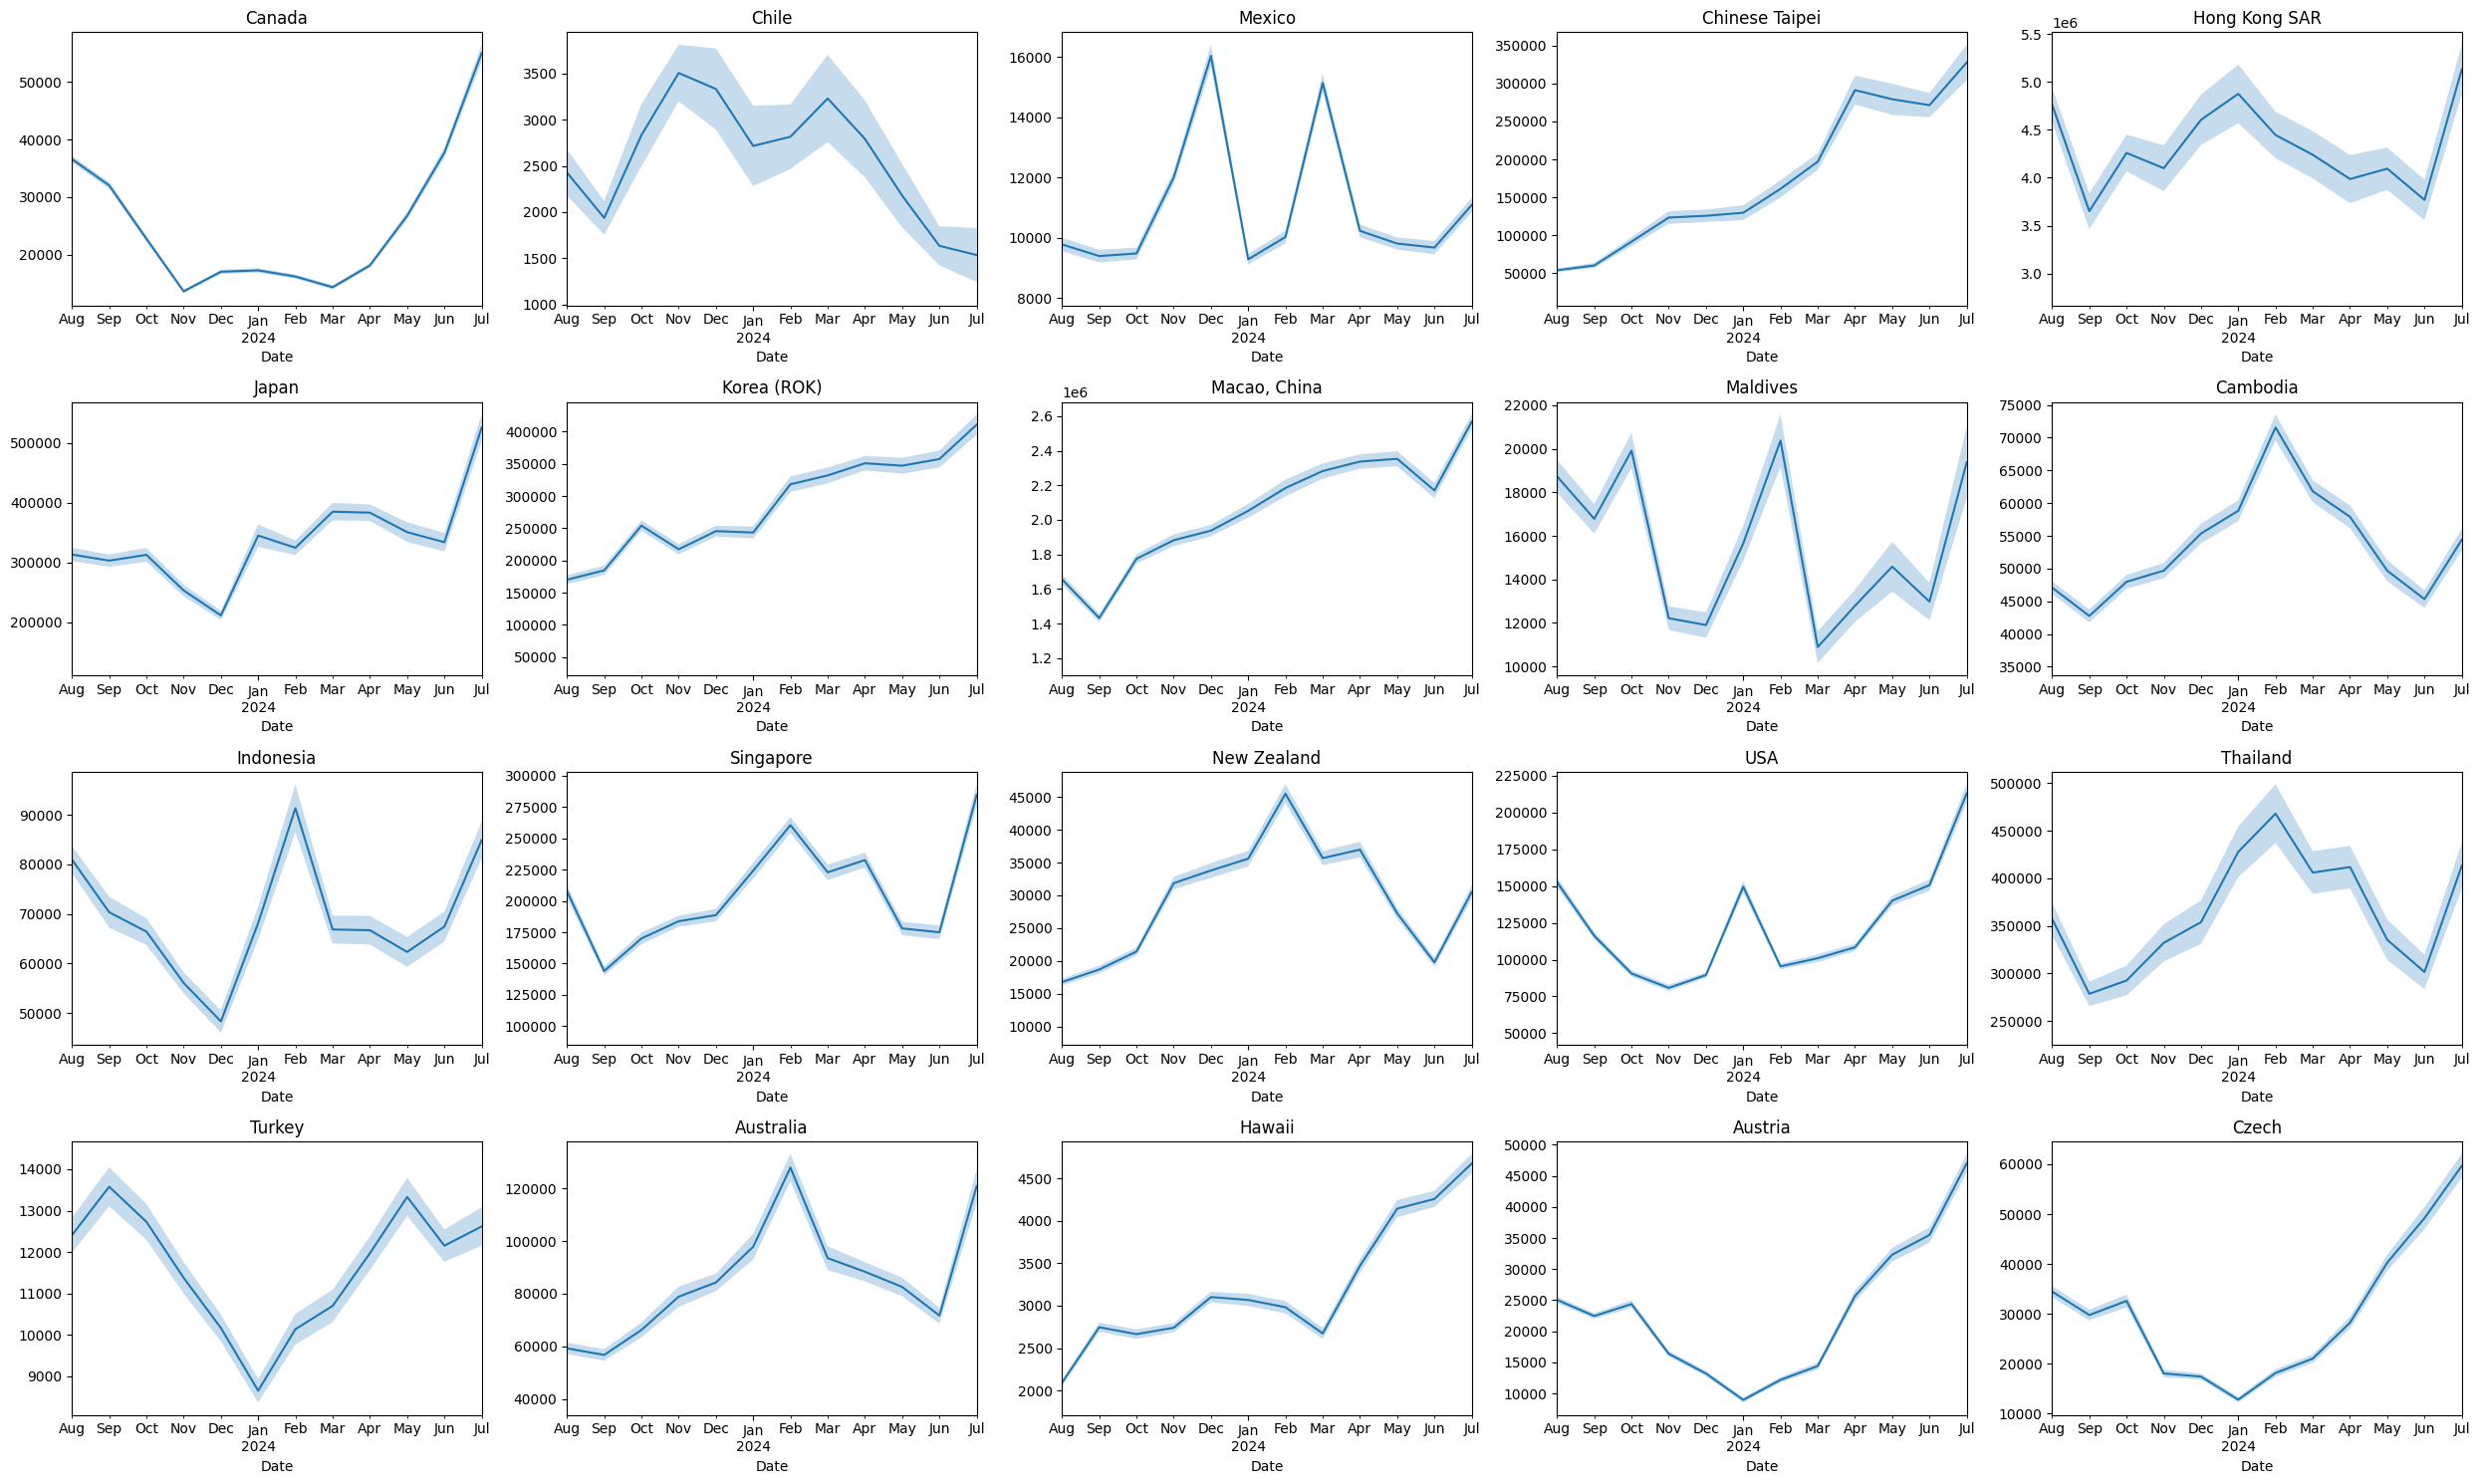

In [328]:
interval_save_path = './data/interval_prediction.csv'
interval_df = final_interval_process(final_pred, dt, all_lower, all_upper, plot=True)
interval_df.to_csv(interval_save_path)

In [329]:
interval_df

CanadaLower  CanadaUpper  ChileLower  ChileUpper  MexicoLower  \
Date                                                                        
2023-08-01        36020        37195        2177        2677         9560   
2023-09-01        31456        32641        1754        2119         9188   
2023-10-01        22275        23263        2494        3170         9287   
2023-11-01        13321        13938        3197        3811        11785   
2023-12-01        16668        17402        2892        3769        15673   
2024-01-01        16879        17665        2279        3151         9117   
2024-02-01        15836        16565        2465        3164         9817   
2024-03-01        13986        14706        2756        3700        14844   
2024-04-01        17715        18553        2374        3208        10023   
2024-05-01        26101        27412        1833        2521         9613   
2024-06-01        36828        38632        1422        1846         9456   
2024-07-01        53570        56516        1243        1827        10850   

            MexicoUpper  Chinese TaipeiLower  Chinese TaipeiUpper  \
Date                                                                
2023-08-01        10005                51061                55971   
2023-09-01         9607                56410                63294   
2023-10-01         9678                85625                97082   
2023-11-01        12227               114753               131501   
2023-12-01        16415               117257               133720   
2024-01-01         9459               119629               139262   
2024-02-01        10243               149595               172451   
2024-03-01        15441               186109               207875   
2024-04-01        10444               272246               310574   
2024-05-01        10012               258781               300087   
2024-06-01         9902               255584               287628   
2024-07-01        11331               304490               351538   

            Hong Kong SARLower  Hong Kong SARUpper  ...  TurkeyLower  \
Date                                                ...                
2023-08-01             4584272             4943875  ...        11985   
2023-09-01             3463504             3839189  ...        13105   
2023-10-01             4066552             4450792  ...        12297   
2023-11-01             3859831             4339800  ...        10996   
2023-12-01             4341745             4867295  ...         9835   
2024-01-01             4569972             5182492  ...         8366   
2024-02-01             4203560             4688465  ...         9763   
2024-03-01             3992593             4486683  ...        10307   
2024-04-01             3735210             4237580  ...        11564   
2024-05-01             3873705             4316140  ...        12868   
2024-06-01             3556661             3980325  ...        11763   
2024-07-01             4869248             5389400  ...        12153   

            TurkeyUpper  AustraliaLower  AustraliaUpper  HawaiiLower  \
Date                                                                   
2023-08-01        12828           56998           61405         2056   
2023-09-01        14049           54521           58905         2690   
2023-10-01        13162           63394           69013         2607   
2023-11-01        11755           74979           82720         2685   
2023-12-01        10492           80949           87604         3039   
2024-01-01         8931           92980          102761         2995   
2024-02-01        10506          122731          133156         2909   
2024-03-01        11089           88989           98029         2608   
2024-04-01        12376           84695           92007         3390   
2024-05-01        13793           79033           86086         4041   
2024-06-01        12545           68640           74730         4162   
2024-07-01        130